## 목적
- 기기변경 시 단말기 추천을 위한 EDA

## 기본 질문
1. 한 달에 기변이 얼마나 일어나는지?
    - 카테고리별로 세분화(제조사, 단말기, 가격대 등)
2. 기변 시 상품 카테고리별 수
    - 카테고리별로 세분화(제조사, 단말기, 가격대 등)
3. 기변하는 사람들의 특징
    - 나이, 요금제 등
4. 요금제 변경과 함께하는 기변? 아니면 단순 기변?

## Package

In [7]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
print(plt.rcParams['font.family'])

['NanumGothicCoding']


In [2]:
plt.rcParams['font.family'] = 'NanumGothicCoding'
print(plt.rcParams['font.family'])

['NanumGothicCoding']


## Load data

In [9]:
DATA_PATH = '/home/dmig/work/chg_device/data/'
MODEL_PATH = '/home/dmig/work/chg_device/model/'

In [2]:
sql = """
SELECT  distinct a.svc_mgmt_num -- 서비스관리번호
,       a.chg_dt -- 변경날짜
,       a.rep_eqp_mdl_cd -- 단말대표코드
,       a.eqp_mdl_cd -- 단말코드
,       a.rep_eqp_yn -- 대표단말여부
,       a.eqp_mdl_nm -- 단말명칭
,       a.mfact_nm -- 단말제조사명칭
,       a.mktg_dt -- 단말출시일
,       a.out_prc -- 단말출고가(단말 변경하는 월의 해당 단말의 출고가)
,       a.sale_chnl_cl_cd
,       seq_chg -- 단말변경순서(최신순)
from comm.change_device_history a
"""

In [3]:
conn = hive_connection('dmig')

In [4]:
df_chg_device = load_from_hive(conn, sql)

2019-08-15 23:01:02,251 - YE_HIVE - INFO - ...tmp_db name = tmp_20190815_23_01_02_9bf6517343338c071ffe8e614a0f26bd80a46325
2019-08-15 23:01:02,253 - YE_HIVE - INFO - Start creating table
2019-08-15 23:01:02,253 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190815_23_01_02_9bf6517343338c071ffe8e614a0f26bd80a46325
2019-08-15 23:01:02,305 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190815_23_01_02_9bf6517343338c071ffe8e614a0f26bd80a46325' is done
2019-08-15 23:02:51,928 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190815_23_01_02_9bf6517343338c071ffe8e614a0f26bd80a46325 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
SELECT  distinct a.svc_mgmt_num -- 서비스관리번호
,       a.chg_dt -- 변경날짜
,       a.rep_eqp_mdl_cd -- 단말대표코드
,       a.eqp_mdl_cd -- 단말코드
,       a.rep_eqp_yn -- 대표단말여

In [36]:
df_chg_device.shape

(13676499, 13)

In [7]:
df_chg_device.to_pickle(os.path.join(DATA_PATH, 'df_chg_device.pkl'))

In [135]:
df_chg_device = pd.read_pickle(os.path.join(DATA_PATH, 'df_chg_device.pkl'))

In [136]:
df_chg_device.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn      eqp_mdl_nm  \
0   1000003019  20190424           A0XK       A138          N  갤럭시S10 5G_256G   
1   1000003308  20160811           SS71       SS74          N     갤럭시J5(2016)   
2   1000013408  20170930           SS3U       SS3U          Y         J5 2017   
3   1000015108  20170824           SS3E       SS3I          N       갤럭시S8_64G   
4   1000015803  20160910           SS3X       SS64          N       갤럭시S7_64G   

  mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg  
0  삼성전자(주)  20190405  1397000            1101        1  
1  삼성전자(주)  20160429   297000            1004        3  
2  삼성전자(주)  20170704   344300            1802        1  
3  삼성전자(주)  20170418   935000            1702        1  
4  삼성전자(주)  20160311   880000            1001        1

## 기본 질문

#### 1. 한 달에 기변이 몇 번 일어나는지?

#### 2. 기변하는 상품의 정보(제조사, 단말기, 가격 등)

#### 3. 기변하는 사람들의 정보(나이, 요금제 등)

#### 4. 요금제와 함께 기변? 아니면 단순 기변?

#### 5. svc_chg_rsn_cd 살펴보기, 보험으로 기변하는 사람들도 있음

In [137]:
# 시점
df_chg_device['yr'] = df_chg_device['chg_dt'].str[:4]
df_chg_device['ym'] = df_chg_device['chg_dt'].str[:6]
df_chg_device['mm'] = df_chg_device['chg_dt'].str[4:6]

In [86]:
def cal_quarter(m):
    return (m-1)//3 + 1

df_chg_device['quarter'] = df_chg_device['mm'].astype(int).apply(cal_quarter)

In [87]:
df_chg_device.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn      eqp_mdl_nm  \
0   1000003019  20190424           A0XK       A138          N  갤럭시S10 5G_256G   
1   1000003308  20160811           SS71       SS74          N     갤럭시J5(2016)   
2   1000013408  20170930           SS3U       SS3U          Y         J5 2017   
3   1000015108  20170824           SS3E       SS3I          N       갤럭시S8_64G   
4   1000015803  20160910           SS3X       SS64          N       갤럭시S7_64G   

  mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg    yr      ym  \
0  삼성전자(주)  20190405  1397000            1101        1  2019  201904   
1  삼성전자(주)  20160429   297000            1004        3  2016  201608   
2  삼성전자(주)  20170704   344300            1802        1  2017  201709   
3  삼성전자(주)  20170418   935000            1702        1  2017  201708   
4  삼성전자(주)  20160311   880000            1001        1  2016  201609   

   days_from_release  mm  quarter  
0                 19  04        2  
1                104  08        3  
2                 88  09        3  
3                128  08        3  
4                183  09        3

## 9999 삭제

In [138]:
df_chg_device = df_chg_device[~df_chg_device['mktg_dt'].str.contains('9999')]

In [103]:
#### 구매일 - 출시일

In [139]:
df_chg_device['days_from_release'] = pd.to_datetime(df_chg_device['chg_dt']) - pd.to_datetime(df_chg_device['mktg_dt'])

df_chg_device['days_from_release'] = df_chg_device['days_from_release'].dt.days

yr:  2016
quarter:  1

(750382, 16)
Top 10 단말기


갤럭시노트5_32G      78943
아이폰6S_64G       64558
갤럭시노트5_64G      44421
갤럭시S7_32G       42113
갤럭시S6_64G       40927
갤럭시 그랜드 맥스      39309
J5              38009
갤럭시 A7(2016)    30159
갤럭시 A8          29018
갤럭시S7엣지_32G     25918
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       528190
Apple          99812
LG전자(주)        92777
TCT Mobile     18764
TG&Co.          8820
Name: mfact_nm, dtype: int64

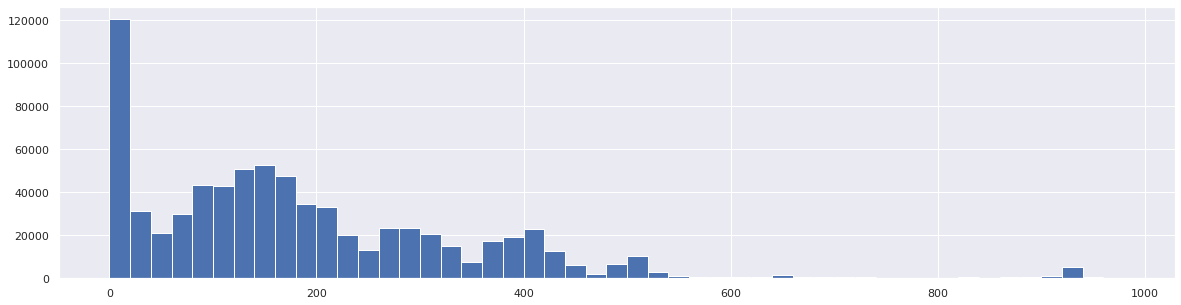

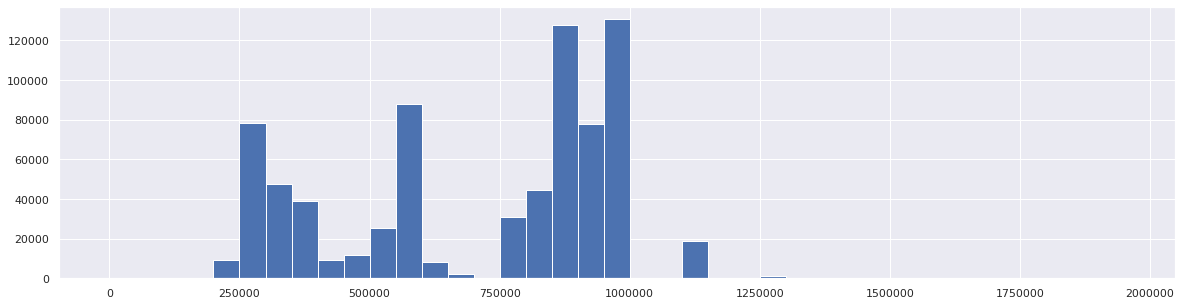

yr:  2016
quarter:  2

(732644, 16)
Top 10 단말기


갤럭시S7_32G      154892
갤럭시S7엣지_32G     64016
G5              42502
아이폰6S_64G       40387
갤럭시노트5_32G      37602
갤럭시S7_64G       34801
갤럭시A3           28696
갤럭시S7엣지_64G     24955
갤럭시J5(2016)     20565
J5              19444
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       538574
LG전자(주)        94730
Apple          74049
TCT Mobile     12315
TG&Co.         10759
Name: mfact_nm, dtype: int64

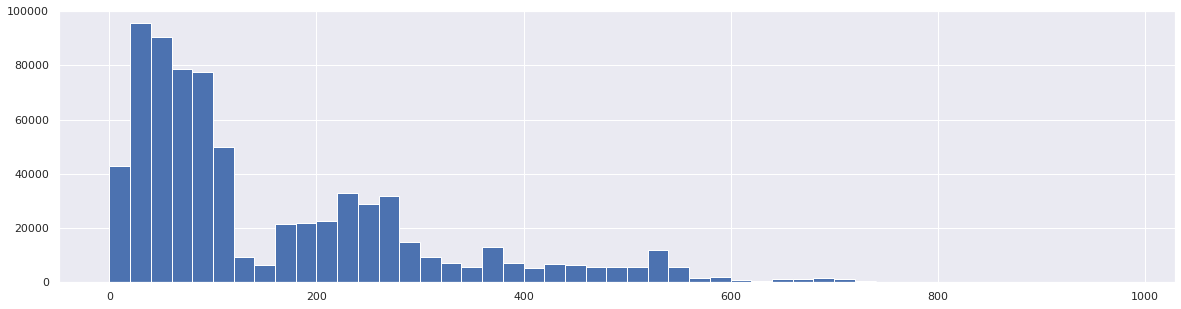

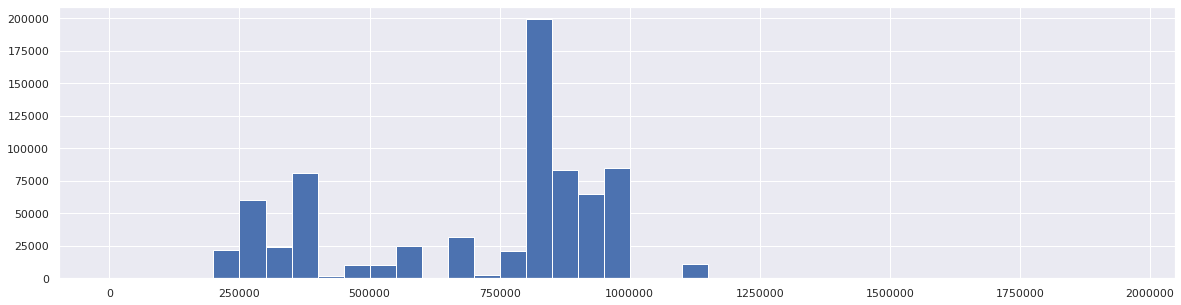

yr:  2016
quarter:  3

(793219, 16)
Top 10 단말기


갤럭시노트7            157410
갤럭시S7_32G         136924
갤럭시S7엣지_32G        47495
갤럭시 WIDE           35132
갤럭시S6 EDGE_64G     29956
아이폰6S_64G          26869
갤럭시A3              26154
갤럭시S7_64G          23298
갤럭시J5(2016)        21304
갤럭시노트5_32G         20388
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       622774
LG전자(주)        83036
Apple          63981
팬택             14432
TCT Mobile      5013
Name: mfact_nm, dtype: int64

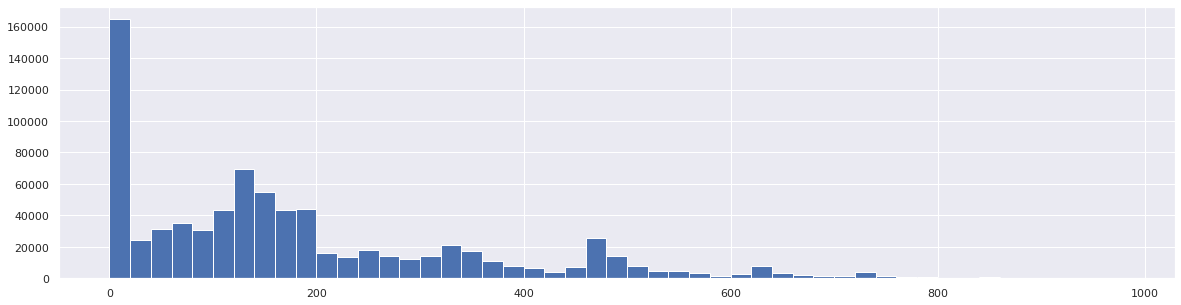

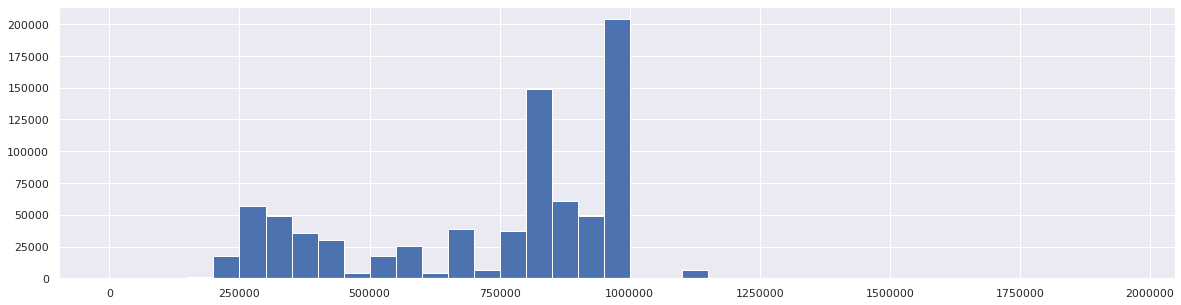

yr:  2016
quarter:  4

(1006452, 16)
Top 10 단말기


갤럭시S7_32G        131713
갤럭시S7엣지_32G      116833
IPHONE7_128G     113796
IPHONE7+_128G     74355
갤럭시S7엣지_64G       59988
V20               45059
갤럭시A8(2016)       44928
갤럭시 WIDE          37383
IPHONE7_32G       36508
갤럭시노트7            35873
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)    607834
Apple      264921
LG전자(주)     99229
TG&Co.      19795
팬택           7573
Name: mfact_nm, dtype: int64

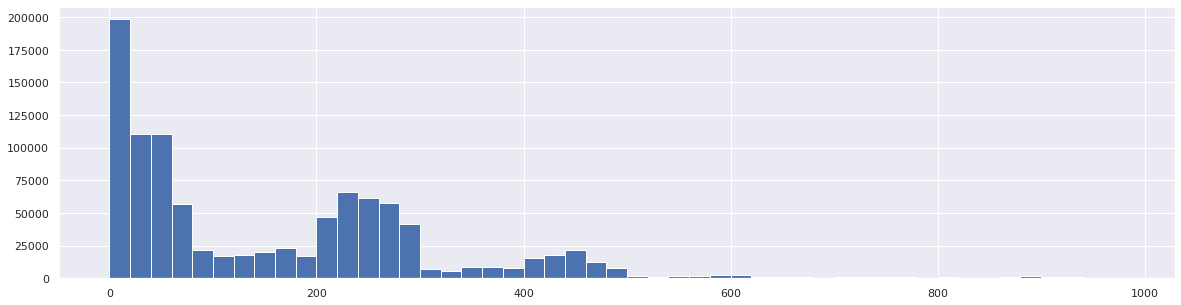

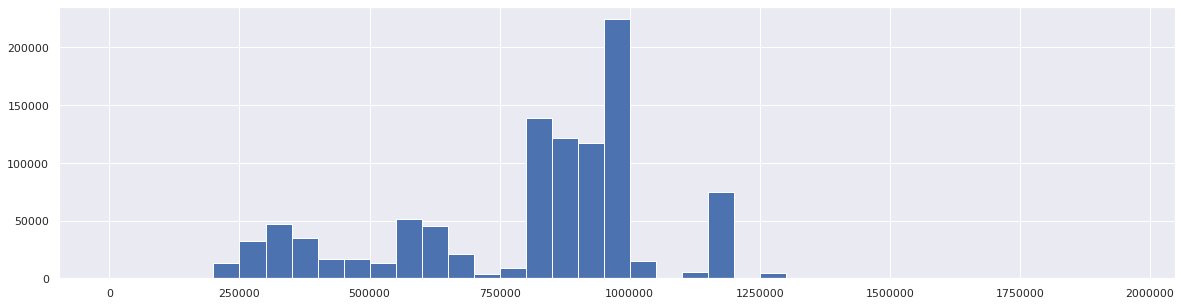

yr:  2017
quarter:  1

(707096, 16)
Top 10 단말기


갤럭시S7_32G        87269
갤럭시노트5_64G       62688
IPHONE7_128G     60318
갤럭시 A5(2017)     45546
갤럭시A8(2016)      36072
IPHONE7+_128G    34586
갤럭시S7엣지_64G      31958
갤럭시 WIDE         30370
갤럭시ON7(2016)     26775
갤럭시S7엣지_32G      21804
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       453705
Apple         129373
LG전자(주)        74362
TG&Co.         21288
TCT Mobile     17742
Name: mfact_nm, dtype: int64

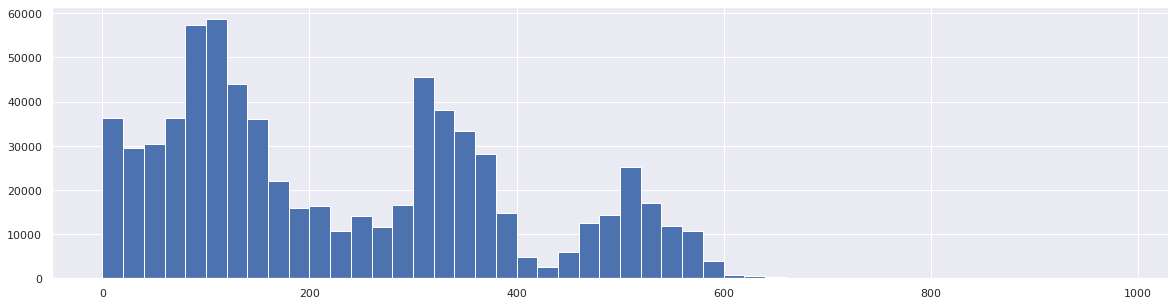

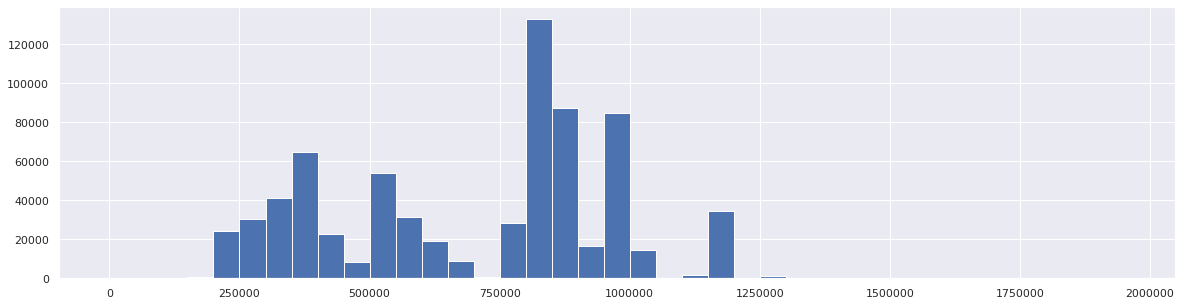

yr:  2017
quarter:  2

(892807, 16)
Top 10 단말기


갤럭시S8_64G       156756
갤럭시S8+_64G      136082
갤럭시S8+_128G      74327
갤럭시노트5_64G       46843
IPHONE7_128G     45215
갤럭시 A5(2017)     42325
갤럭시A8(2016)      41317
G6               41116
갤럭시S7_32G        33070
루나S              24221
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       669184
Apple          96114
LG전자(주)        93017
TG&Co.         24364
TCT Mobile      5104
Name: mfact_nm, dtype: int64

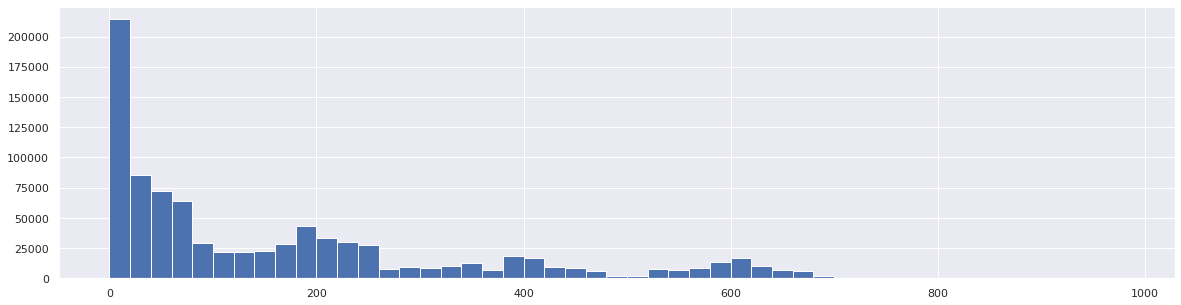

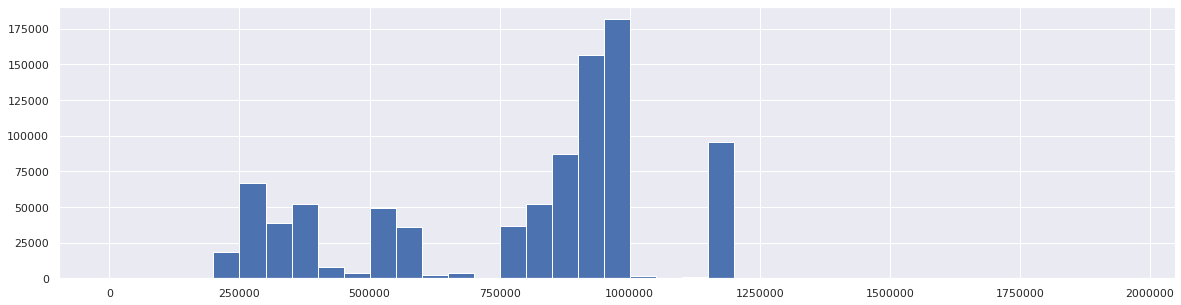

yr:  2017
quarter:  3

(1099689, 16)
Top 10 단말기


갤럭시S8_64G             124973
갤럭시 노트 8_64G          122256
갤럭시 노트 Fan Edition    105070
갤럭시 노트 8_256G          93328
갤럭시S8+_64G             93324
J5 2017                47893
A7 2017                47324
IPHONE7_128G           42781
갤럭시 A5(2017)           40185
WIDE2                  38423
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       855690
LG전자(주)       122172
Apple          94925
TCT Mobile     15401
TG&Co.          7676
Name: mfact_nm, dtype: int64

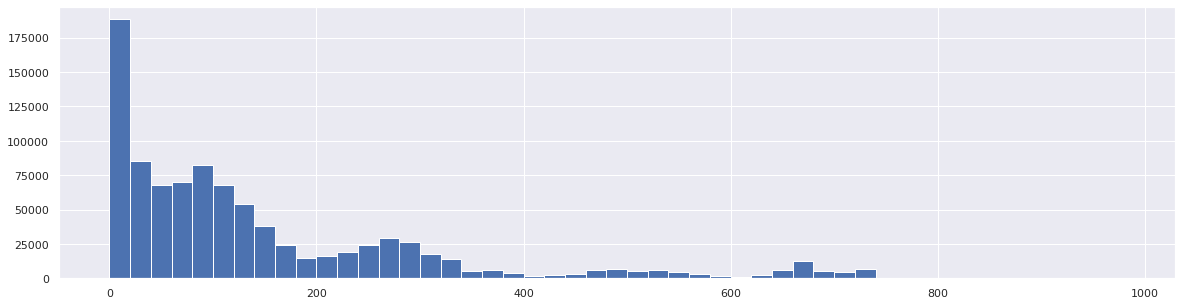

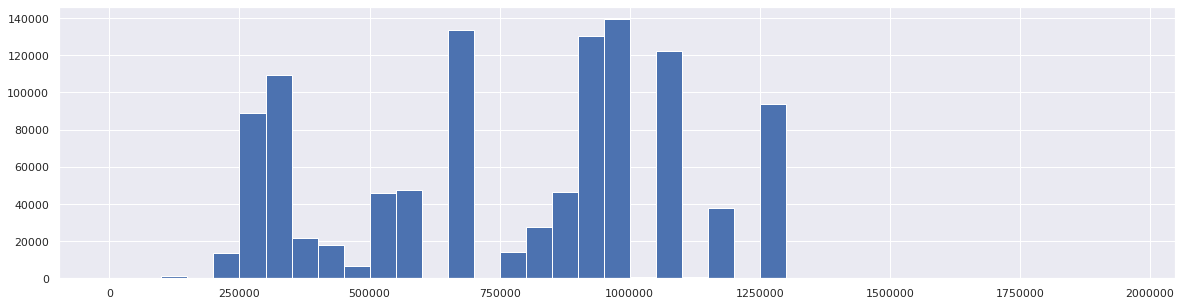

yr:  2017
quarter:  4

(1010766, 16)
Top 10 단말기


갤럭시 노트 8_64G     203099
갤럭시S8_64G         86866
IPHONE8_64G       70636
갤럭시 노트 8_256G     52321
A7 2017           51642
J5 2017           42709
IPHONE_X_256G     38282
WIDE2             34406
갤럭시S8+_64G        34038
갤럭시ON7(2016)      32921
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       647021
Apple         239936
LG전자(주)        96442
TCT Mobile     23040
(주)에스모바일        2068
Name: mfact_nm, dtype: int64

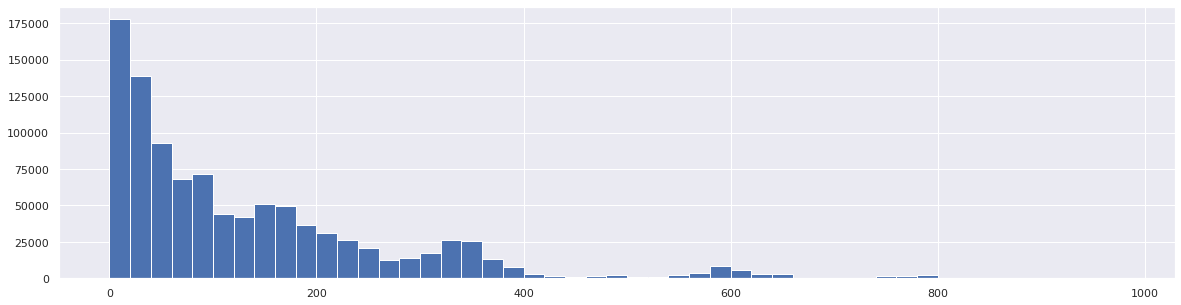

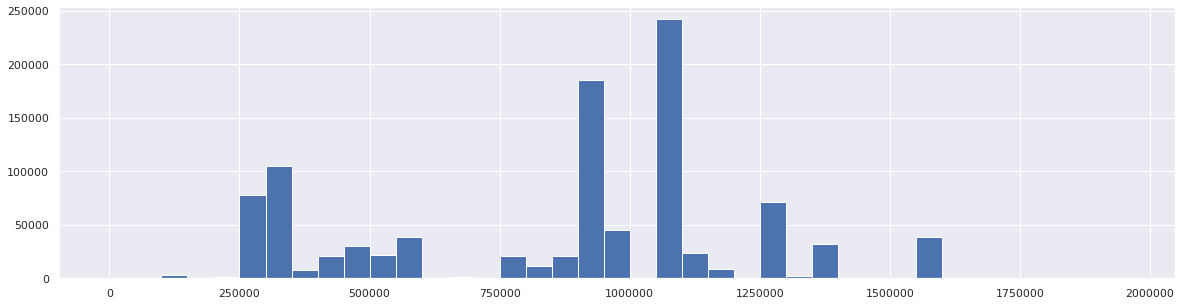

yr:  2018
quarter:  1

(1074867, 16)
Top 10 단말기


갤럭시 노트 8_64G    155444
갤럭시 A8(2018)    111853
갤럭시 S9_64G       58468
갤럭시S8_64G        56750
갤럭시 S9+_64G      51408
IPHONE8_64G      47844
갤럭시 S9+_256G     46432
J5 2017          43161
WIDE2            36690
A7 2017          33751
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)       780840
Apple         181488
LG전자(주)       100700
(주)에스모바일        7428
TCT Mobile      2086
Name: mfact_nm, dtype: int64

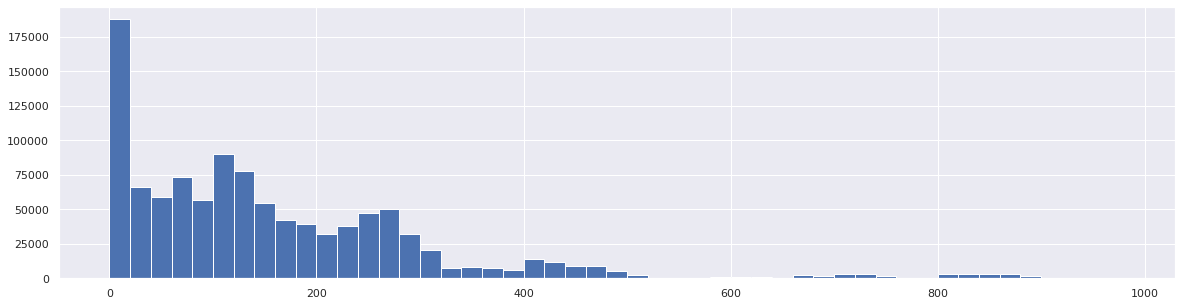

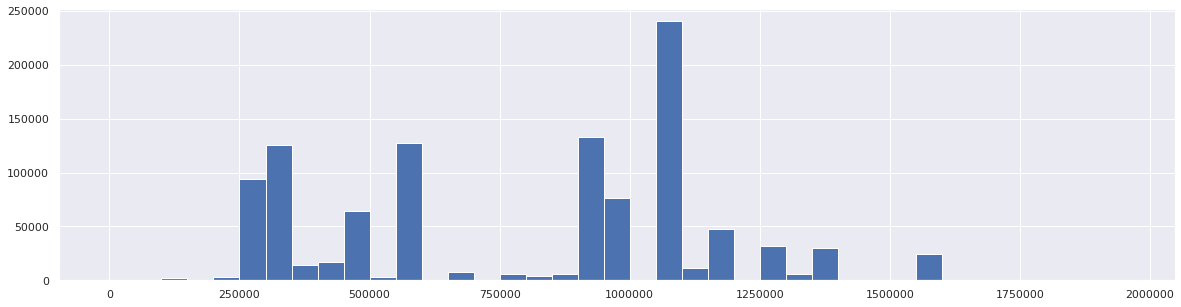

yr:  2018
quarter:  2

(1045697, 16)
Top 10 단말기


갤럭시 S9+_256G    108398
갤럭시S8_64G       102676
갤럭시 S9_64G       94682
갤럭시 S9+_64G      66014
갤럭시 A8(2018)     59915
갤럭시 노트 8_64G     57685
IPHONE8_64G      48078
On 7 Prime       46216
J5 2017          34533
갤럭시폴더2           27766
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)     759262
Apple       173337
LG전자(주)     102819
(주)에스모바일      6325
캐치웰           1082
Name: mfact_nm, dtype: int64

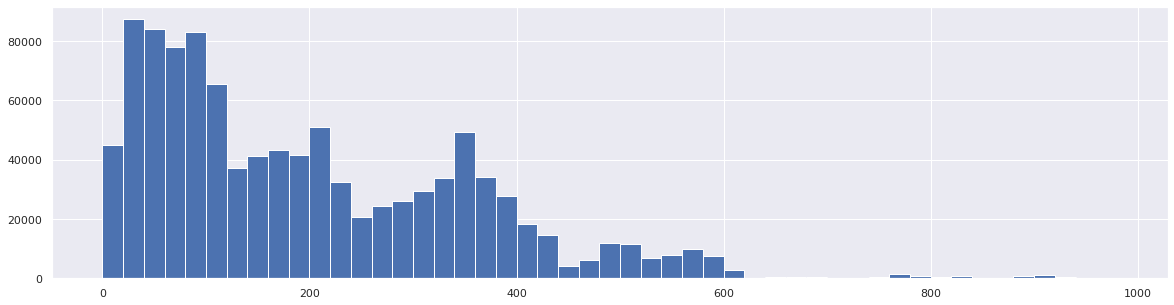

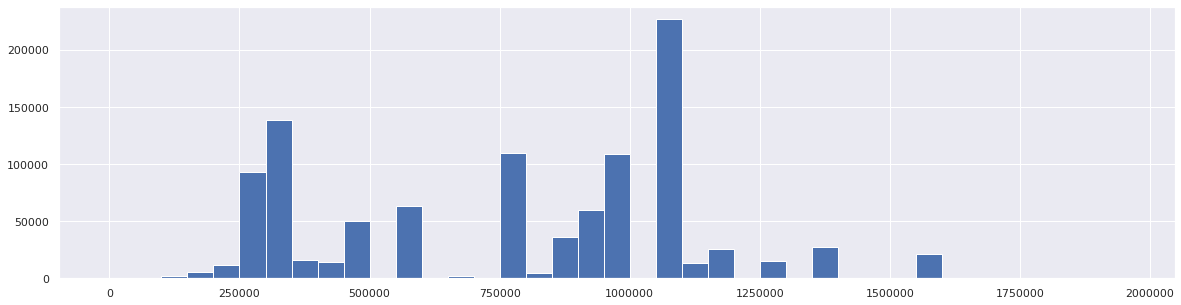

yr:  2018
quarter:  3

(1126653, 16)
Top 10 단말기


갤럭시 노트 9_128G    161746
갤럭시 S9_64G       113433
갤럭시 노트 9_512G     84505
WIDE3             66292
갤럭시 A8 Star       54388
갤럭시 노트 8_64G      50215
갤럭시S8_64G         46651
IPHONE8_64G       44314
On 7 Prime        38301
갤럭시 S9+_64G       35550
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)     845168
Apple       145540
LG전자(주)     125192
(주)에스모바일      5488
샤오미           2628
Name: mfact_nm, dtype: int64

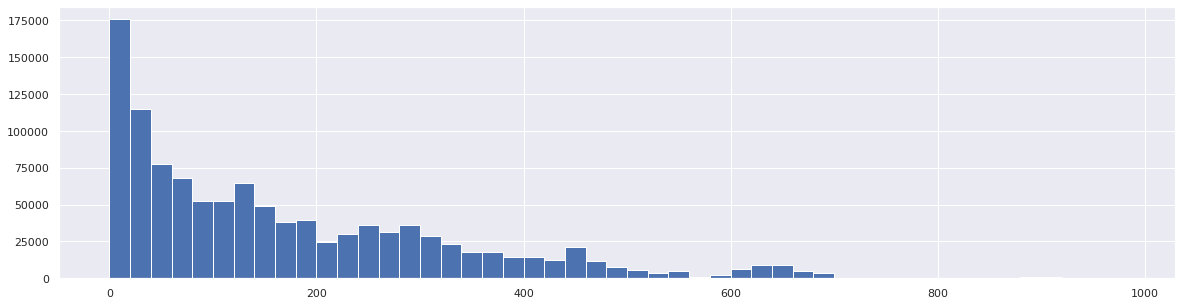

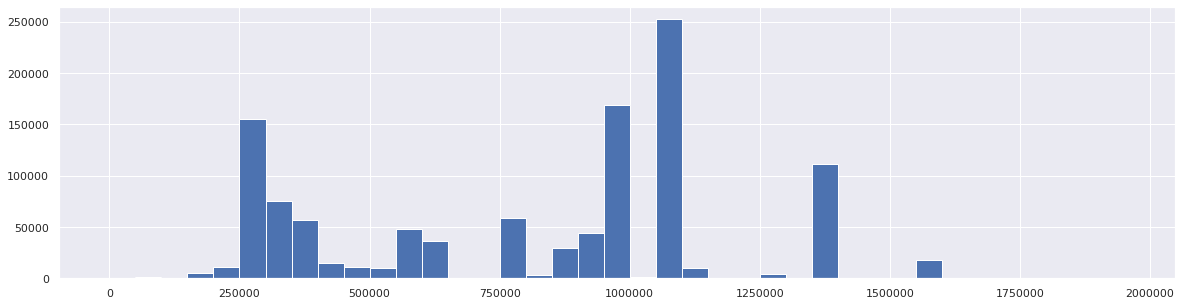

yr:  2018
quarter:  4

(1026933, 16)
Top 10 단말기


갤럭시 노트 9_128G     236549
WIDE3              71186
갤럭시 S9_64G         61850
IPHONE XS_256G     59612
IPHONE XS_64G      57534
갤럭시S8_64G          45169
삼성 갤럭시 A7          44785
갤럭시 A8 Star        41564
갤럭시 A6             31893
갤럭시 노트 9_512G      27437
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)     661765
Apple       250604
LG전자(주)     102799
(주)에스모바일      3079
샤오미           2312
Name: mfact_nm, dtype: int64

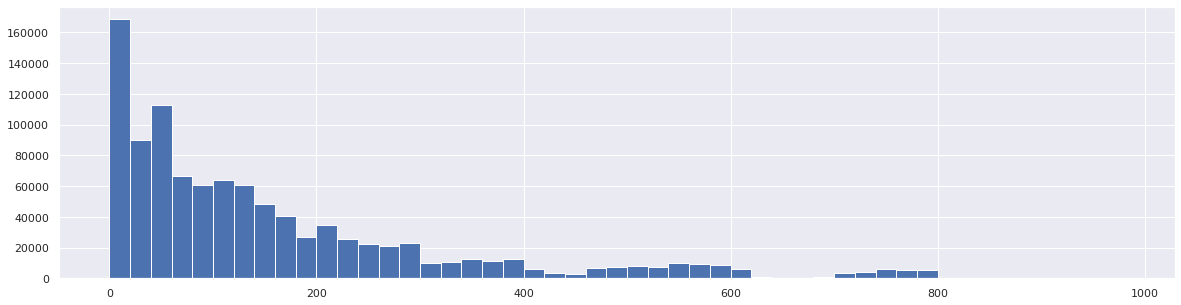

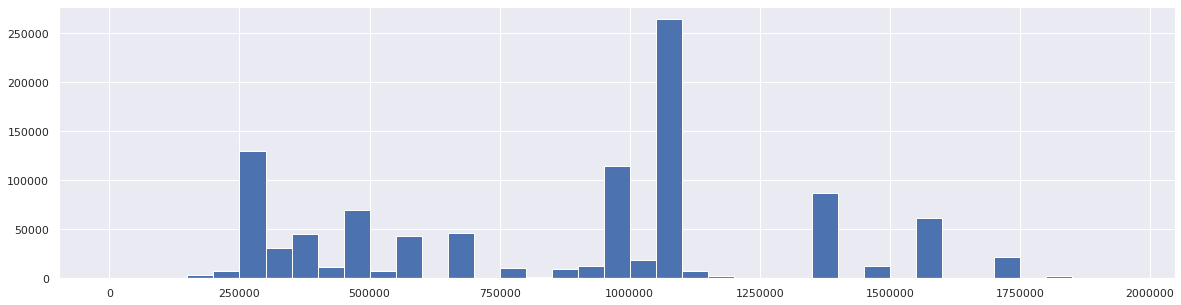

yr:  2019
quarter:  1

(948878, 16)
Top 10 단말기


갤럭시 노트 9_128G     151229
갤럭시S8_64G          66416
WIDE3              61602
갤럭시 S10_128G       58515
갤럭시 S10+_128G      39465
갤럭시 S9_64G         38934
갤럭시 A6             38087
IPHONE XS_64G      34223
IPHONE XS_256G     31479
갤럭시 A8 Star        30517
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)     700558
Apple       156895
LG전자(주)      81389
(주)에스모바일      5931
SHARP         1888
Name: mfact_nm, dtype: int64

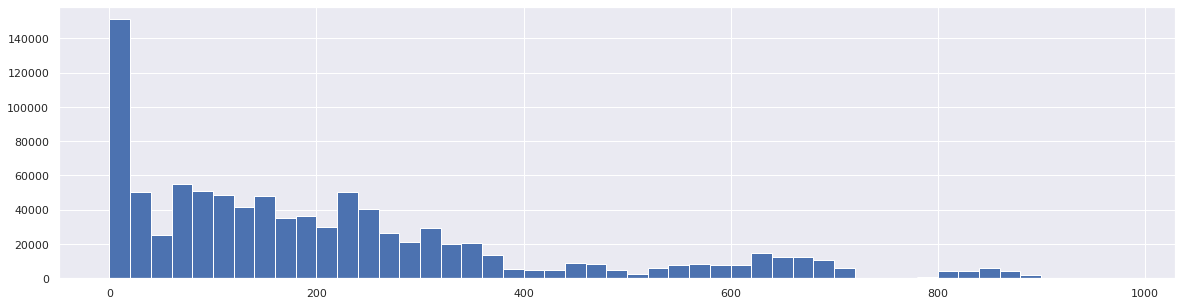

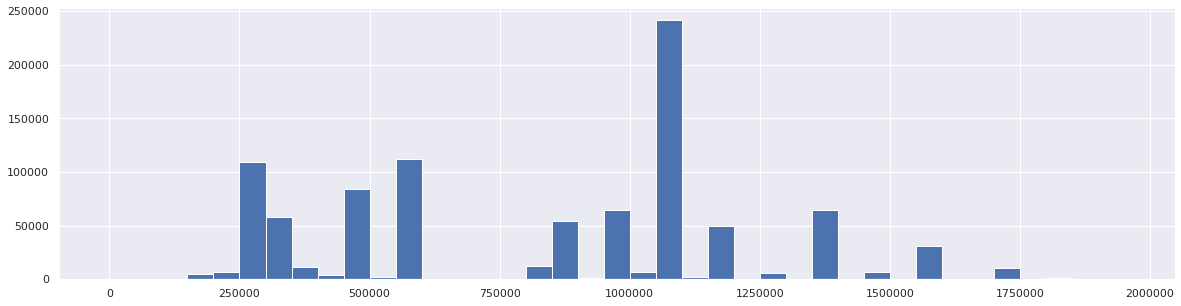

yr:  2019
quarter:  2

(970074, 16)
Top 10 단말기


갤럭시S10 5G_256G    280956
V50                56224
갤럭시 S10e           54646
갤럭시S10 5G_512G     38685
WIDE3              34922
갤럭시 Wide 4         33518
갤럭시 S10_128G       32985
갤럭시S8_64G          30306
갤럭시 A9 PRO         28018
갤럭시 노트 9_128G      24334
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)     713586
LG전자(주)     128940
Apple       121833
(주)에스모바일      2942
XIAOMI        1249
Name: mfact_nm, dtype: int64

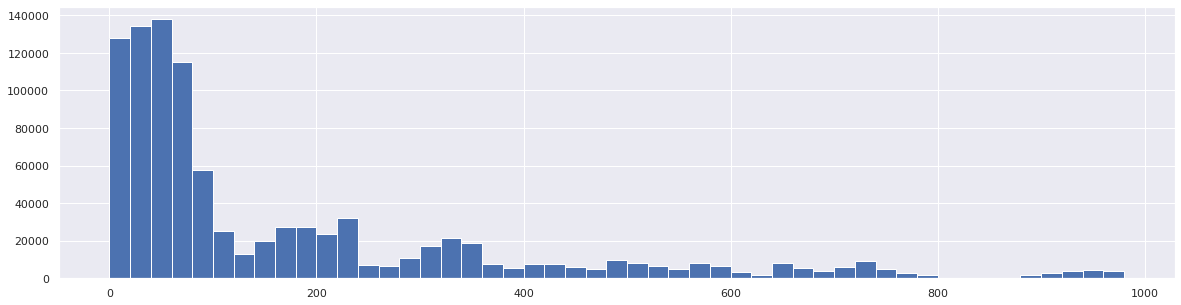

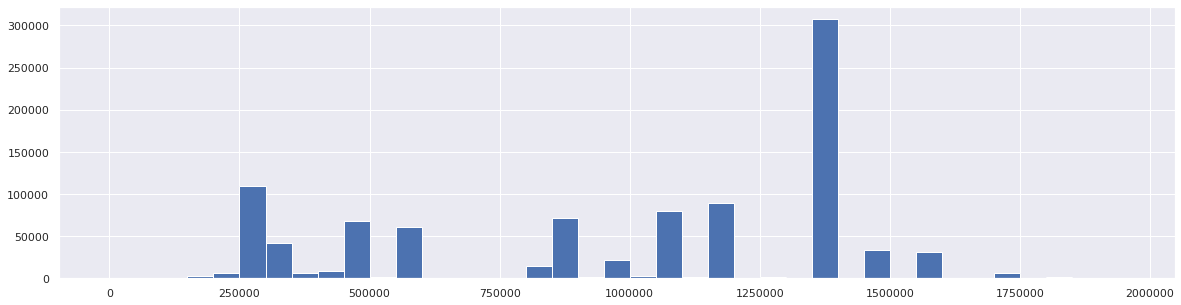

yr:  2019
quarter:  3

(490338, 16)
Top 10 단말기


갤럭시S10 5G_256G    157489
갤럭시S10 5G_512G     55582
갤럭시 Wide 4         38102
V50                31765
갤럭시 S10e           17542
갤럭시 노트 9_128G      16313
A50                14898
IPHONE XR_64G      13063
IPHONE XR_128G     10191
IPHONE XS_256G     10048
Name: eqp_mdl_nm, dtype: int64


Top 5 제조사


삼성전자(주)     370718
LG전자(주)      63148
Apple        54822
(주)에스모바일      1007
휴컴와이어리스        198
Name: mfact_nm, dtype: int64

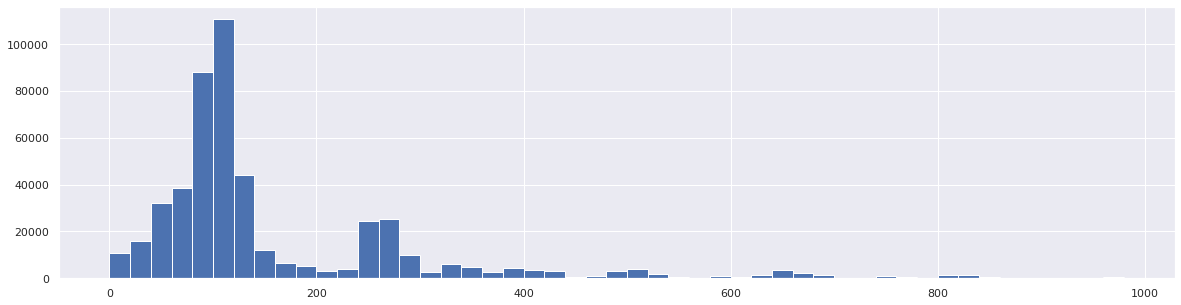

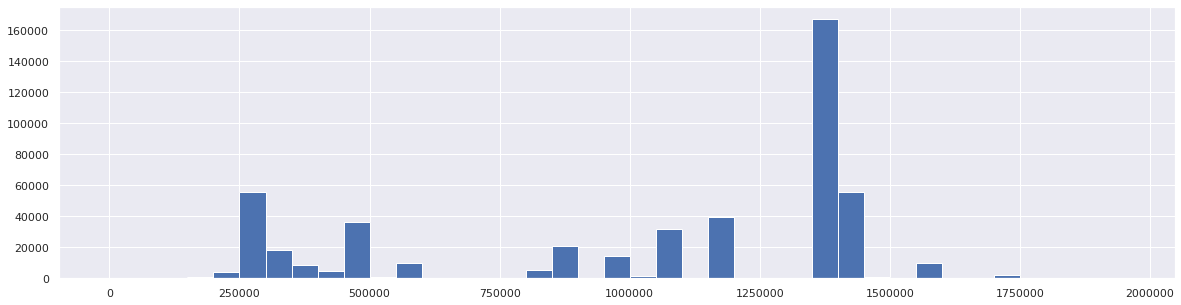

yr:  2019
quarter:  4

(0, 16)
Top 10 단말기


Series([], Name: eqp_mdl_nm, dtype: int64)


Top 5 제조사


Series([], Name: mfact_nm, dtype: int64)

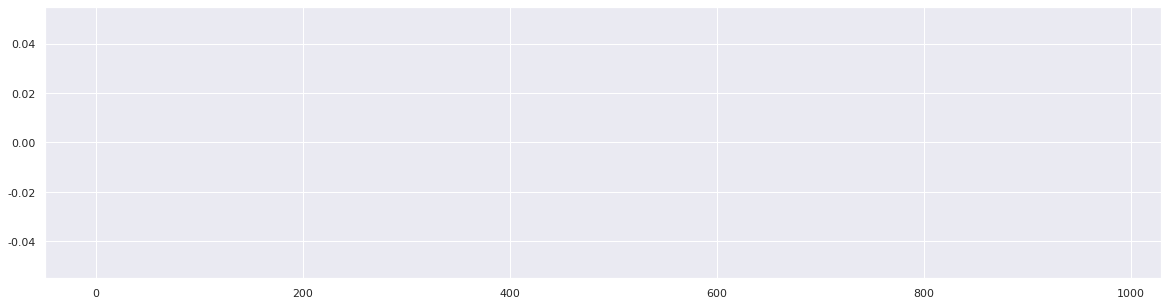

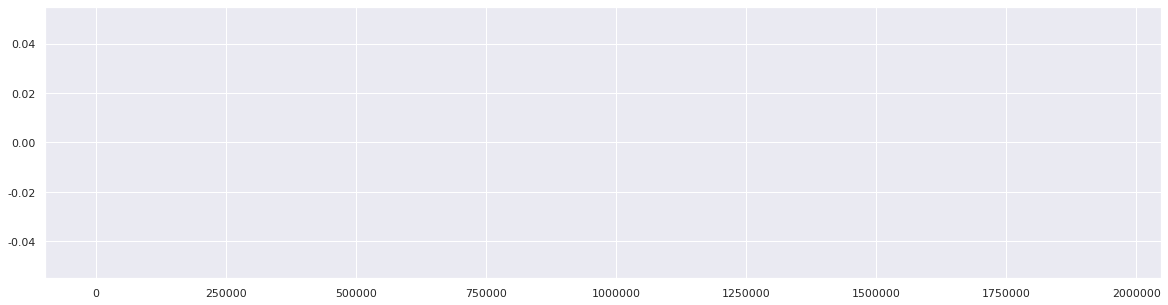

In [100]:
for yr in ['2016', '2017', '2018', '2019']:
    
    for quarter in [1,2,3,4]:
        print('='*50)
        print('yr: ', yr)
        print('quarter: ', quarter)
        print('')
        
        df_tmp = df_chg_device[df_chg_device['yr']==yr]
        df_tmp = df_tmp[df_tmp['quarter']==quarter]
        
        print(df_tmp.shape)
        
        # Top10 단말기
        print('Top 10 단말기')
        df_top10 = df_tmp['eqp_mdl_nm'].value_counts().sort_values(ascending=False).iloc[:10]
        display(df_top10)
        print('')
        
        # 제조사
        print('Top 5 제조사')
        display(df_tmp['mfact_nm'].value_counts().sort_values(ascending=False).iloc[:5])
        print('')
        
        # 최신폰?
        sns.set(rc={'figure.figsize': (20,5)})
        df_tmp['days_from_release'].hist(bins =np.arange(0,1000,20))
        plt.show()


        # 가격대
        sns.set(rc={'figure.figsize': (20,5)})
        df_tmp['out_prc'].astype(int).hist(bins =np.arange(0,2000000,50000))
        plt.show()

In [102]:
df_chg_device[df_chg_device['eqp_mdl_nm'].str.contains('갤럭시 노트 9')]

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
11       1000080201  20190107           A0M0       A0M0          Y   
13       1000116109  20180910           A0M0       A0M1          N   
16       1000133208  20180929           A0M0       A0M0          Y   
22       1000190108  20180821           A0M0       A0M0          Y   
47       1000548903  20180922           A0M7       A0M7          Y   
50       1000624211  20180821           A0M7       A0N8          N   
68       1001739514  20181128           A0M0       A0PP          N   
81       1002196506  20180922           A0M0       A0M0          Y   
177      1005307104  20190117           A0M0       A0PP          N   
188      1005710401  20180918           A0M0       A0M1          N   
207      1006657009  20181213           A0M7       A0N8          N   
229      1007975504  20181222           A0M0       A0PP          N   
237      1008379204  20180929           A0M0       A0M0          Y   
243      1008687705  20181023           A0M0       A0PP          N   
269      1010085310  20180825           A0M0       A0M4          N   
309      1011030914  20190107           A0M0       A0M3          N   
324      1011806610  20180911           A0M0       A0M0          Y   
329      1011930410  20181117           A0M0       A0M4          N   
335      1012135208  20181001           A0M0       A0M5          N   
361      1013076116  20180917           A0M0       A0M4          N   
388      1014093304  20180821           A0M7       A0M7          Y   
394      1014359009  20181011           A0M0       A0PP          N   
396      1014444610  20190307           A0M0       A0M0          Y   
411      1014978002  20181217           A0M0       A0M4          N   
427      1015647710  20180821           A0M7       A0M7          Y   
453      1016562808  20181003           A0M0       A0M4          N   
454      1016725402  20181022           A0M7       A0N8          N   
455      1016854109  20190121           A0M0       A0PP          N   
467      1017496608  20190107           A0M7       A0M7          Y   
485      1018677404  20181015           A0M0       A0M2          N   
...             ...       ...            ...        ...        ...   
227526   7293995936  20180927           A0M7       A0M7          Y   
227535   7294080526  20181030           A0M0       A0M4          N   
227537   7294130803  20181019           A0M0       A0M4          N   
227545   7294185576  20181105           A0M0       A0M1          N   
227555   7294264163  20190221           A0M0       A0M2          N   
227558   7294271314  20181224           A0M0       A0PP          N   
227579   7294470124  20181025           A0M0       A0M0          Y   
227589   7294536457  20181107           A0M0       A0M4          N   
227590   7294582625  20190222           A0M0       A0VW          N   
227596   7294604841  20190729           A0M0       A0M4          N   
227628   7294868464  20190126           A0M0       A0PQ          N   
227647   7295065830  20190304           A0M0       A0PP          N   
227657   7295172805  20181102           A0M7       A0M7          Y   
227658   7295197877  20190117           A0M0       A0M2          N   
227674   7295330475  20190108           A0M0       A0M0          Y   
227703   7295696731  20190107           A0M0       A0M0          Y   
227704   7295729579  20181011           A0M0       A0M4          N   
227776   7296614237  20181219           A0M0       A0M1          N   
227799   7296847487  20181211           A0M0       A0M4          N   
227814   7297116919  20190329           A0M7       A0VY          N   
227816   7297146369  20181120           A0M0       A0PP          N   
227837   7297362363  20190218           A0M0       A0M2          N   
227854   7297507460  20190115           A0M0       A0VX          N   
227898   7298076168  20181228           A0M0       A0M2          N   
227902   7298126441  20181227           A0M0       A0M0          Y   
227908   72982327

#### 대략 30만 회선

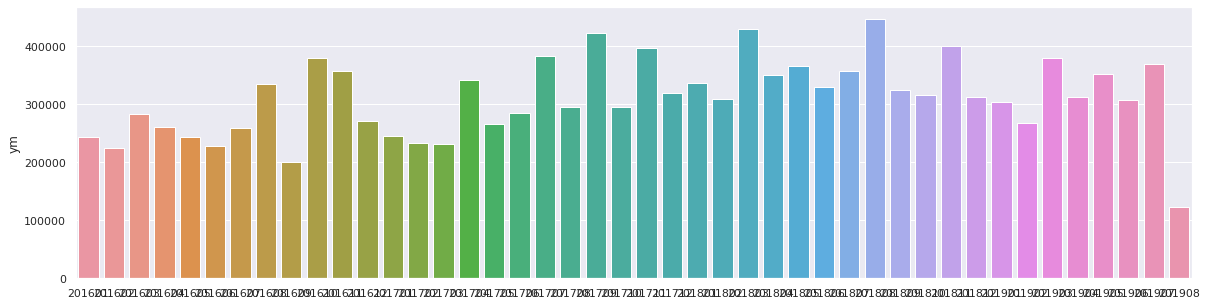

In [49]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=df_chg_device['ym'].value_counts().index, y=df_chg_device['ym'].value_counts(), ax=ax)

#### top3(삼성, lg, apple)만 보기

In [52]:
df_top3 = df_chg_device[df_chg_device['mfact_nm'].isin(['삼성전자(주)', 'LG전자(주)', 'Apple'])]

In [53]:
df_top3.shape[0]/df_chg_device.shape[0]

0.9770961852152368

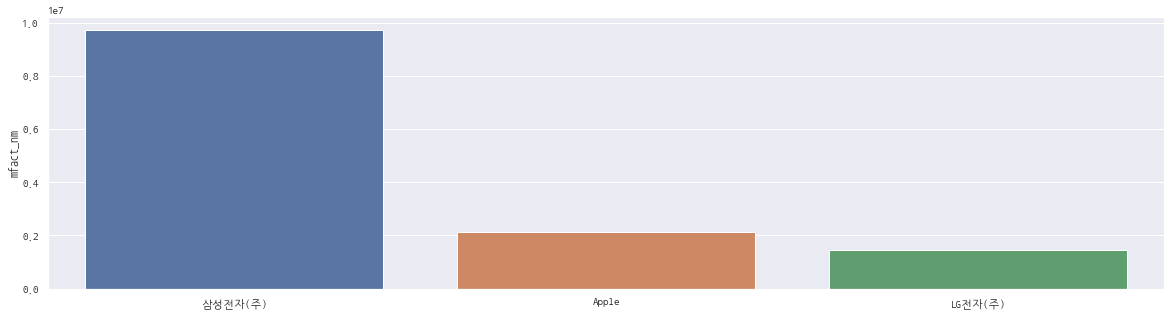

In [63]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=df_top3['mfact_nm'].value_counts().index, y=df_top3['mfact_nm'].value_counts(), ax=ax, )

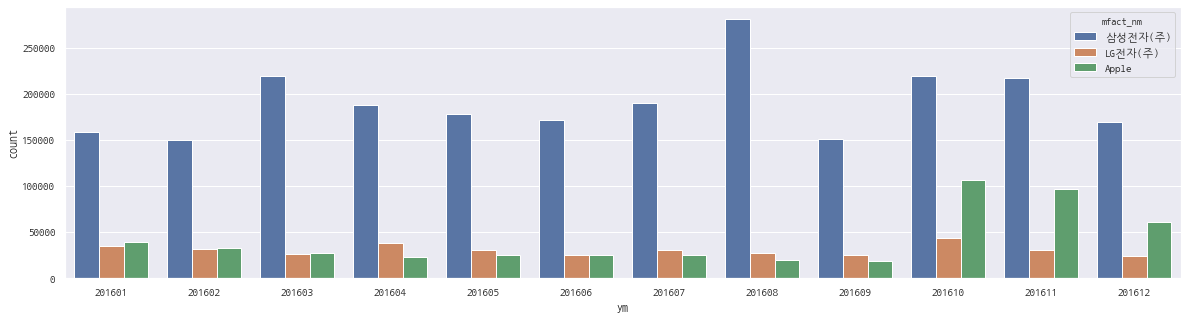

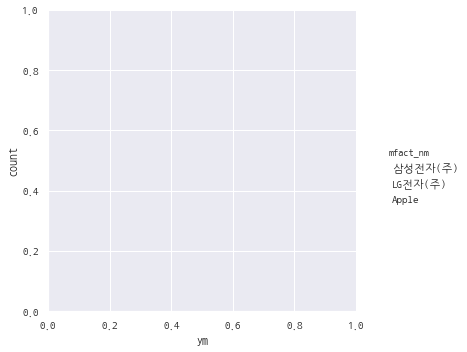

In [67]:
df_tmp = df_chg_device[df_chg_device.yr=='2016']
fig, ax = plt.subplots(figsize=(20,5))
sns.catplot(x="ym", hue="mfact_nm", kind="count", data=df_tmp[df_tmp['mfact_nm'].isin(['삼성전자(주)', 'LG전자(주)', 'Apple'])], ax=ax)

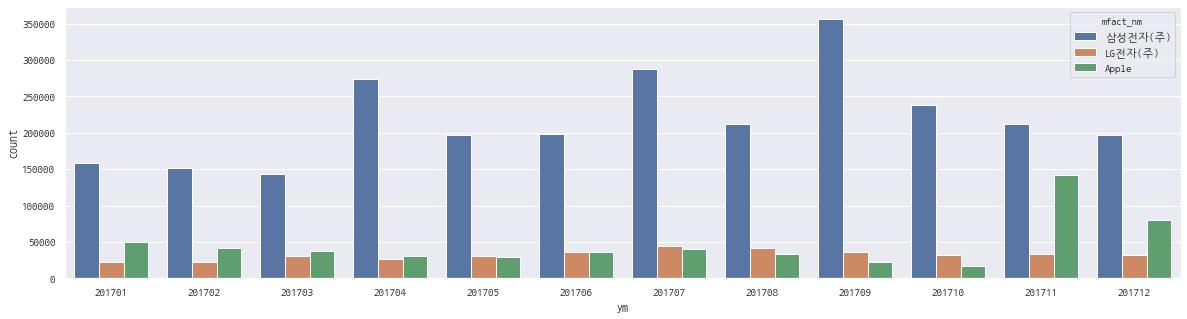

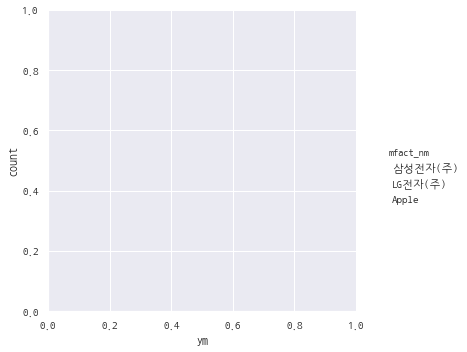

In [64]:
df_tmp = df_chg_device[df_chg_device.yr=='2017']
fig, ax = plt.subplots(figsize=(20,5))
sns.catplot(x="ym", hue="mfact_nm", kind="count", data=df_tmp[df_tmp['mfact_nm'].isin(['삼성전자(주)', 'LG전자(주)', 'Apple'])], ax=ax)

In [104]:
df = df_chg_device[df_chg_device.yr=='2018']
df = df[df.mm == '10']
df[]

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
193      1005872107  20181016           A0G3       A0G3          Y   
200      1006189203  20181003           SS30       SS49          N   
243      1008687705  20181023           A0M0       A0PP          N   
261      1009768310  20181011           A0G6       A0G6          Y   
310      1011051718  20181010           A0G3       A0G3          Y   
332      1012071314  20181002           A0GF       A0GH          N   
335      1012135208  20181001           A0M0       A0M5          N   
336      1012158603  20181016           SS3E       SS3E          Y   
394      1014359009  20181011           A0M0       A0PP          N   
446      1016342701  20181003           A0B2       A0B2          Y   
452      1016557202  20181012           A0B1       A05S          N   
453      1016562808  20181003           A0M0       A0M4          N   
454      1016725402  20181022           A0M7       A0N8          N   
463      1017461101  20181027           A0OP       A0OQ          N   
485      1018677404  20181015           A0M0       A0M2          N   
493      1019068201  20181017           CGJA       CGJA          Y   
569      1021658411  20181002           A0B1       A05U          N   
607      1022630901  20181020           A0M0       A0M0          Y   
612      1022756312  20181026           A0G3       A0G3          Y   
645      1023930503  20181018           CGJA       CGJA          Y   
858      1032376510  20181008           A0AX       A0AX          Y   
885      1033300010  20181015           A0G3       A0G3          Y   
968      1037073806  20181011           A0HJ       A0HJ          Y   
990      1038447509  20181009           A06M       A0AR          N   
998      1038876300  20181013           A0G3       A0H3          N   
1020     1040016305  20181018           A0HJ       A0J9          N   
1033     1040098800  20181010           A06M       A0AS          N   
1056     1040335110  20181022           A0HJ       A0J9          N   
1096     1041792018  20181018           A0BU       A0BU          Y   
1153     1043714409  20181020           A0M0       A0M5          N   
...             ...       ...            ...        ...        ...   
227301   7292037105  20181030           A0I7       A0I7          Y   
227304   7292045047  20181008           A08C       A08D          N   
227308   7292080353  20181011           A0AF       A0AF          Y   
227315   7292133479  20181013           A05W       A068          N   
227318   7292149063  20181015           A0M0       A0PP          N   
227355   7292466788  20181017           A0M7       A0M7          Y   
227373   7292610130  20181002           A03S       A06F          N   
227394   7292763744  20181022           A0M0       A0M4          N   
227406   7292963253  20181015           A05O       A0HA          N   
227408   7292974329  20181018           A0BU       A0BW          N   
227417   7293118927  20181031           A0G3       A0H4          N   
227427   7293197940  20181027           A0FE       A0FE          Y   
227431   7293241791  20181006           SS3U       SS3U          Y   
227473   7293549140  20181001           A0M0       A0M0          Y   
227482   7293614887  20181030           A0AF       A0AF          Y   
227513   7293891656  20181011           A03F       A03F          Y   
227535   7294080526  20181030           A0M0       A0M4          N   
227537   7294130803  20181019           A0M0       A0M4          N   
227538   7294140579  20181030           A0AF       A0AF          Y   
227579   7294470124  20181025           A0M0       A0M0          Y   
227670   7295279092  20181011           A05O       A05O          Y   
227675   7295359684  20181018           A0HJ       A0J9          N   
227704   7295729579  20181011           A0M0       A0M4          N   
227712   7295762402  20181009           A08C       A08D          N   
227716   7295800967  20181022           A03S       A06F          N   
227721   72958306

In [105]:
df[df['mfact_nm']=='Apple']

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
493      1019068201  20181017           CGJA       CGJA          Y   
645      1023930503  20181018           CGJA       CGJA          Y   
4310     1163147210  20181027           A05O       A05Q          N   
4890     1186495608  20181024           CGJA       CGJA          Y   
7086     1269056700  20181010           A05X       A05Z          N   
7190     1272504301  20181026           A05O       A05Q          N   
7792     1296880604  20181027           A05V       A067          N   
9280     1355528303  20181016           A05V       A067          N   
10321    1396406604  20181031           CGN8       CGIQ          N   
13427    1515417000  20181031           CGJA       CGJA          Y   
14011    1540254507  20181008           A05O       A0HA          N   
14540    1560767214  20181018           A05O       A0HA          N   
16368    1632429000  20181023           A05X       A05Z          N   
16728    1645338912  20181005           A05V       A066          N   
16805    1649325608  20181018           A05O       A0HA          N   
17067    1659160709  20181006           CGN2       CGIF          N   
18293    1704091905  20181001           A05O       A0HA          N   
18918    1729763204  20181005           A05O       A05O          Y   
20775    1802839718  20181001           A05O       A05O          Y   
21065    1813820112  20181003           A05W       A069          N   
24433    1950218101  20181019           CGN2       CGIE          N   
27019    7004013280  20181001           A05X       A05Z          N   
27607    7005636102  20181031           A05J       A05J          Y   
29531    7010728555  20181018           A063       A063          Y   
30803    7013865838  20181009           A05O       A05O          Y   
32064    7016739407  20181008           CGJA       CGJA          Y   
32391    7017387536  20181001           A05X       A05Z          N   
32652    7017857762  20181011           A05V       A066          N   
32970    7018423723  20181016           CGN2       CGIF          N   
34327    7020953036  20181009           A05X       A05Z          N   
...             ...       ...            ...        ...        ...   
221586   7277161436  20181031           A05O       A05O          Y   
221764   7277420971  20181004           A05W       A069          N   
222091   7277903455  20181018           A05X       A05Z          N   
222269   7278184886  20181019           CGJA       CGJA          Y   
222370   7278373251  20181003           CGJA       CGJA          Y   
222851   7279094336  20181017           A05X       A05Z          N   
223094   7279436314  20181015           A05O       A0HA          N   
223314   7279780439  20181004           A05O       A05O          Y   
223998   7281153321  20181005           CGJA       CGJA          Y   
224030   7281213183  20181008           CGN2       CGIF          N   
224124   7281375746  20181019           CGNY       CGHM          N   
224169   7281469908  20181012           A05W       A068          N   
224313   7281730184  20181015           CGJA       CGJA          Y   
224834   7282962137  20181009           A05X       A05Z          N   
224957   7283224475  20181012           A060       A0HC          N   
225099   7283518399  20181010           CGN4       CGIG          N   
225422   7284324985  20181003           A05X       A05Z          N   
225592   7284774988  20181009           CGN8       CGIQ          N   
225829   7285390151  20181017           A05O       A05P          N   
226052   7286024829  20181013           A05V       A067          N   
226211   7286637835  20181013           A05O       A05O          Y   
226725   7288448070  20181002           CGN8       CGIQ          N   
227042   7290225289  20181016           A05X       A05Y          N   
227095   7290651710  20181001           A05V       A066          N   
227145   7290914870  20181001           A05V       A066          N   
227296   72920060

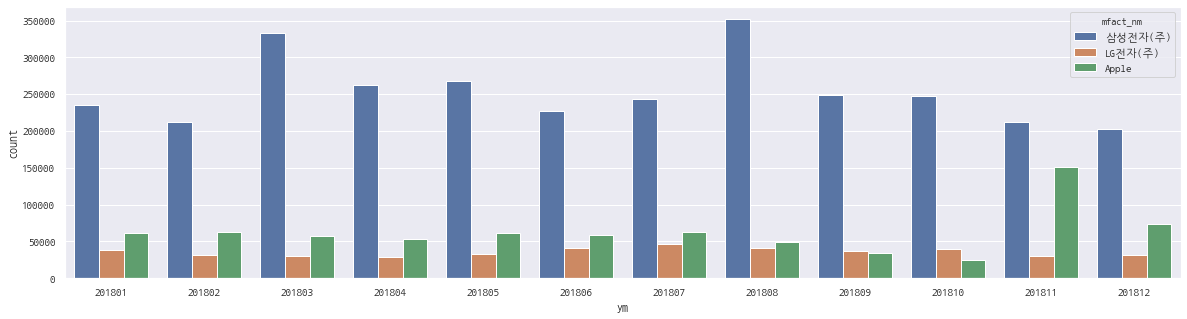

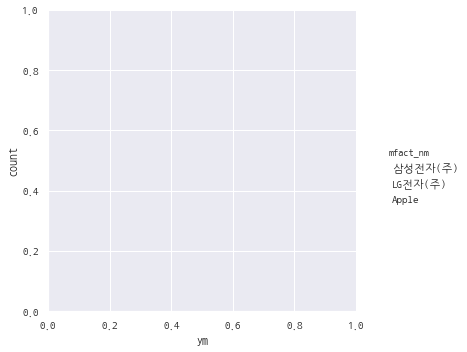

In [65]:
df_tmp = df_chg_device[df_chg_device.yr=='2018']
fig, ax = plt.subplots(figsize=(20,5))
sns.catplot(x="ym", hue="mfact_nm", kind="count", data=df_tmp[df_tmp['mfact_nm'].isin(['삼성전자(주)', 'LG전자(주)', 'Apple'])], ax=ax)

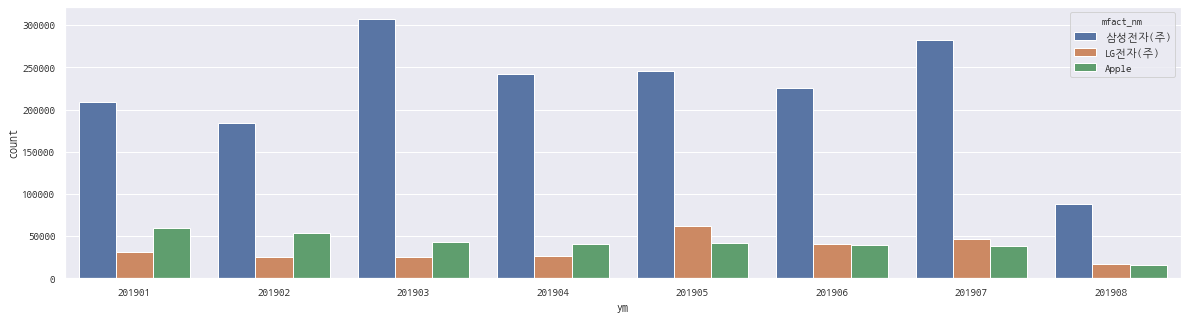

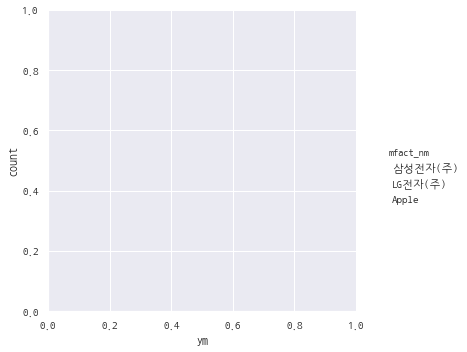

In [66]:
df_tmp = df_chg_device[df_chg_device.yr=='2019']
fig, ax = plt.subplots(figsize=(20,5))
sns.catplot(x="ym", hue="mfact_nm", kind="count", data=df_tmp[df_tmp['mfact_nm'].isin(['삼성전자(주)', 'LG전자(주)', 'Apple'])], ax=ax)

In [35]:
df_chg_device[df_chg_device['mfact_nm'].isin(['삼성전자(주)', 'LG전자(주)', 'Apple'])].groupby(['ym', 'mfact_nm']).size()

ym      mfact_nm
201601  Apple        39234
        LG전자(주)      35297
        삼성전자(주)     158553
201602  Apple        32972
        LG전자(주)      31494
        삼성전자(주)     150425
201603  Apple        27606
        LG전자(주)      25986
        삼성전자(주)     219212
201604  Apple        23092
        LG전자(주)      38640
        삼성전자(주)     187909
201605  Apple        25663
        LG전자(주)      30885
        삼성전자(주)     178269
201606  Apple        25294
        LG전자(주)      25205
        삼성전자(주)     172396
201607  Apple        24976
        LG전자(주)      30195
        삼성전자(주)     190148
201608  Apple        19832
        LG전자(주)      27877
        삼성전자(주)     281130
201609  Apple        19173
        LG전자(주)      24964
        삼성전자(주)     151496
201610  Apple       106403
        LG전자(주)      44227
        삼성전자(주)     220194
                     ...  
201811  Apple       151437
        LG전자(주)      30178
        삼성전자(주)     212048
201812  Apple        73753
        LG전자(주)      32266
        삼성전

In [10]:
df_chg_device.groupby(['ym', 'mfact_nm']).size()

ym      mfact_nm            
201601  (주)에스모바일                     1
        (주)인포마크                    133
        Apple                    39234
        LG전자(주)                  35297
        TCT Mobile                4109
        TG&Co.                    5669
        삼성전자(주)                 158553
        팬택                         251
        화웨이                        442
201602  (주)셀리지온                      1
        (주)에스모바일                     1
        (주)인포마크                    276
        Apple                    32972
        LG전자(주)                  31494
        TCT Mobile                7284
        TG&Co.                    1964
        모다정보통신                       1
        삼성전자(주)                 150425
        팬택                          57
        화웨이                        236
201603  (주)인포마크                    421
        Apple                    27606
        LG전자(주)                  25986
        TCT Mobile                7371
        TG&Co.                    1

In [9]:
df_chg_device['ym'].value_counts().sort_index()

201601    243689
201602    224711
201603    281982
201604    260792
201605    243372
201606    228480
201607    259407
201608    333921
201609    199891
201610    378506
201611    356975
201612    270971
201701    244251
201702    232445
201703    230400
201704    341658
201705    266350
201706    284799
201707    382015
201708    295664
201709    422010
201710    295101
201711    396997
201712    318668
201801    336809
201802    308568
201803    429491
201804    350228
201805    365913
201806    329558
201807    357436
201808    445506
201809    323711
201810    315659
201811    399028
201812    312247
201901    303137
201902    267272
201903    378469
201904    311389
201905    351861
201906    306824
201907    368461
201908    121877
Name: ym, dtype: int64

In [ ]:
sns.distplot(df_chg_device['ym'])

In [68]:
df_chg_device.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn      eqp_mdl_nm  \
0   1000003019  20190424           A0XK       A138          N  갤럭시S10 5G_256G   
1   1000003308  20160811           SS71       SS74          N     갤럭시J5(2016)   
2   1000013408  20170930           SS3U       SS3U          Y         J5 2017   
3   1000015108  20170824           SS3E       SS3I          N       갤럭시S8_64G   
4   1000015803  20160910           SS3X       SS64          N       갤럭시S7_64G   

  mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg      ym    yr  
0  삼성전자(주)  20190405  1397000            1101        1  201904  2019  
1  삼성전자(주)  20160429   297000            1004        3  201608  2016  
2  삼성전자(주)  20170704   344300            1802        1  201709  2017  
3  삼성전자(주)  20170418   935000            1702        1  201708  2017  
4  삼성전자(주)  20160311   880000            1001        1  201609  2016

In [69]:
df_tmp = df_chg_device[df_chg_device.yr=='2019']

In [70]:
df_tmp.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
0    1000003019  20190424           A0XK       A138          N   
9    1000052305  20190710           A0ZK       A0ZM          N   
10   1000065508  20190719           A0XK       A0XK          Y   
11   1000080201  20190107           A0M0       A0M0          Y   
14   1000118705  20190625           A124       A124          Y   

        eqp_mdl_nm mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg  \
0   갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1101        1   
9    갤럭시 S10+_128G  삼성전자(주)  20190304  1155000            1101        1   
10  갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1303        1   
11   갤럭시 노트 9_128G  삼성전자(주)  20180813  1094500            1101        1   
14         갤럭시 A30  삼성전자(주)  20190503   349800            1001        1   

        ym    yr  
0   201904  2019  
9   201907  2019  
10  201907  2019  
11  201901  2019  
14  201906  2019

In [ ]:
sns.distplot(df_tmp.out_prc)

In [106]:
df_chg_device.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn      eqp_mdl_nm  \
0   1000003019  20190424           A0XK       A138          N  갤럭시S10 5G_256G   
1   1000003308  20160811           SS71       SS74          N     갤럭시J5(2016)   
2   1000013408  20170930           SS3U       SS3U          Y         J5 2017   
3   1000015108  20170824           SS3E       SS3I          N       갤럭시S8_64G   
4   1000015803  20160910           SS3X       SS64          N       갤럭시S7_64G   

  mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg    yr      ym  \
0  삼성전자(주)  20190405  1397000            1101        1  2019  201904   
1  삼성전자(주)  20160429   297000            1004        3  2016  201608   
2  삼성전자(주)  20170704   344300            1802        1  2017  201709   
3  삼성전자(주)  20170418   935000            1702        1  2017  201708   
4  삼성전자(주)  20160311   880000            1001        1  2016  201609   

   days_from_release  mm  quarter  
0                 19  04        2  
1                104  08        3  
2                 88  09        3  
3                128  08        3  
4                183  09        3

In [112]:
df_chg_device['eqp_mdl_nm'].value_counts()

갤럭시S8_64G                  718762
갤럭시S7_32G                  629758
갤럭시 노트 8_64G               628342
갤럭시 노트 9_128G              590171
갤럭시S10 5G_256G             438445
갤럭시 S9_64G                 378023
갤럭시S8+_64G                 296285
갤럭시S7엣지_32G                295491
IPHONE7_128G               273181
WIDE3                      252503
IPHONE8_64G                223670
갤럭시 A8(2018)               223595
갤럭시노트5_64G                 218725
갤럭시 A5(2017)               210540
J5 2017                    207517
갤럭시 S9+_64G                206389
갤럭시노트7                     193314
갤럭시 S9+_256G               191300
갤럭시 노트 8_256G              186466
갤럭시폴더2                     178596
A7 2017                    166588
갤럭시노트5_32G                 165484
갤럭시ON7(2016)               162399
WIDE2                      161959
갤럭시S7엣지_64G                159682
IPHONE7+_128G              154745
갤럭시 A8 Star                143549
On 7 Prime                 140030
아이폰6S_64G                  138967
IPHONE_X_64G  

In [111]:
df_chg_device[(df_chg_device['ym']=='201904')].groupby(['eqp_mdl_nm', 'out_prc']).size().sort_values(ascending=False).

eqp_mdl_nm               out_prc
갤럭시S10 5G_256G           1397000    59944
갤럭시 S10e                 899800     23722
갤럭시 S10_128G             1056000    20387
WIDE3                    297000     20160
갤럭시S8_64G                599500     16698
갤럭시 노트 9_128G            1094500    16559
갤럭시 S10+_128G            1155000    15870
갤럭시 A9 PRO               599500     10759
IPHONE XS_256G           1562000     8223
LG Q9                    499400      8149
IPHONE XS_64G            1364000     8059
갤럭시S10 5G_512G           1556500     8009
갤럭시 노트 8_64G             847000      7268
갤럭시폴더2                   297000      5840
갤럭시 A8 Star              499400      5323
IPHONE XR_64G            990000      5095
갤럭시 S9_64G               858000      4820
IPHONE XR_128G           1056000     4632
갤럭시 A6                   346500      4345
IPHONE_X_64G             1155000     4215
IPHONE7_32G              499400      4028
갤럭시 S10                  1056000     3921
G8                       897600      3455
삼

In [122]:
top_50 = df_chg_device['eqp_mdl_nm'].value_counts().sort_values(ascending=False).iloc[:50]

In [125]:
top_50_device = list(top_50.index)

In [126]:
top_50_device

['갤럭시S8_64G',
 '갤럭시S7_32G',
 '갤럭시 노트 8_64G',
 '갤럭시 노트 9_128G',
 '갤럭시S10 5G_256G',
 '갤럭시 S9_64G',
 '갤럭시S8+_64G',
 '갤럭시S7엣지_32G',
 'IPHONE7_128G',
 'WIDE3',
 'IPHONE8_64G',
 '갤럭시 A8(2018)',
 '갤럭시노트5_64G',
 '갤럭시 A5(2017)',
 'J5 2017',
 '갤럭시 S9+_64G',
 '갤럭시노트7',
 '갤럭시 S9+_256G',
 '갤럭시 노트 8_256G',
 '갤럭시폴더2',
 'A7 2017',
 '갤럭시노트5_32G',
 '갤럭시ON7(2016)',
 'WIDE2',
 '갤럭시S7엣지_64G',
 'IPHONE7+_128G',
 '갤럭시 A8 Star',
 'On 7 Prime',
 '아이폰6S_64G',
 'IPHONE_X_64G',
 '갤럭시 WIDE',
 '갤럭시S8+_128G',
 '갤럭시 노트 9_512G',
 'IPHONE7_32G',
 'IPHONE XS_256G',
 '갤럭시A8(2016)',
 'IPHONE XS_64G',
 '갤럭시S7_64G',
 '갤럭시 A6',
 '갤럭시 노트 Fan Edition',
 'IPHONE_X_256G',
 '갤럭시 A7(2016)',
 '갤럭시 S10_128G',
 '갤럭시S10 5G_512G',
 '갤럭시 S10e',
 'V20',
 '갤럭시A3',
 'V50',
 'V30',
 'IPHONE8+_64G']

In [255]:
df_tmp = df_chg_device[df_chg_device['eqp_mdl_nm'].isin(top_50_device)].groupby(['ym', 'eqp_mdl_nm']).size()

KeyboardInterrupt: 

In [256]:
df_tmp = df_chg_device[df_chg_device['ym'] == '201907']

In [257]:
df_tmp.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
9     1000052305  20190710           A0ZK       A0ZM          N   
10    1000065508  20190719           A0XK       A0XK          Y   
23    1000231501  20190711           A0XK       A134          N   
167   1004965208  20190709           A0XK       A0XK          Y   
203   1006363605  20190730           A152       A14U          N   

         eqp_mdl_nm mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg  \
9     갤럭시 S10+_128G  삼성전자(주)  20190304  1155000            1101        1   
10   갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1303        1   
23   갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1002        1   
167  갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1002        1   
203  갤럭시S10 5G_512G  삼성전자(주)  20190405  1430000            1002        1   

       yr      ym  mm  days_from_release  
9    2019  201907  07                128  
10   2019  201907  07                105  
23   2019  201907  07                 97  
167  2019  201907  07                 95  
203  2019  201907  07                116

In [264]:
df1 = pd.DataFrame(df_tmp.mfact_nm.value_counts())

In [265]:
df1.loc['삼성전자(주)']

mfact_nm    282513
Name: 삼성전자(주), dtype: int64

In [266]:
df1['top1 단말기'] = '테스트'
df1['top1 판매 대수'] = 0

In [269]:
df_tmp[df_tmp.mfact_nm=='삼성전자(주)']['eqp_mdl_nm'].value_counts().sort_values(ascending=False).iloc[:1].index[0]

'갤럭시S10 5G_256G'

In [274]:
df_tmp[df_tmp.mfact_nm=='삼성전자(주)']['eqp_mdl_nm'].value_counts().sort_values(ascending=False).iloc[:1].values[0]

131601

In [282]:
for mfact in df_tmp.mfact_nm.unique():
    print('mfact: ', mfact)
    top1 = df_tmp[df_tmp.mfact_nm==mfact]['eqp_mdl_nm'].value_counts().sort_values(ascending=False).iloc[:1]
    df1.loc[mfact,'top1 단말기'] = top1.index[0]
    df1.loc[mfact,'top1 판매 대수'] = top1.values[0]

mfact:  삼성전자(주)
mfact:  LG전자(주)
mfact:  Apple
mfact:  KyoceraCorp.(젠에이코리아)
mfact:  휴컴와이어리스
mfact:  (주)에스모바일
mfact:  모다정보통신
mfact:  (주)인포마크
mfact:  한국노키아(주)
mfact:  ZTE
mfact:  BlackShark
mfact:  XIAOMI
mfact:  샤오미
mfact:  SHARP


In [280]:
df1.loc['샤오미','top1 단말기'] = 1

In [290]:
df1.columns = ['전체 기변 대수', '대표 단말기', '대표 단말기 기변 대수']

In [291]:
df1

전체 기변 대수                   대표 단말기  대표 단말기 기변 대수
삼성전자(주)                 282513           갤럭시S10 5G_256G        131601
LG전자(주)                  46142                      V50         24625
Apple                    38747            IPHONE XR_64G          9880
(주)에스모바일                   752                    mini폰           452
모다정보통신                     103                   T포켓파이1           103
(주)인포마크                     63                    포켓파이Z            46
KyoceraCorp.(젠에이코리아)        55                  KC-100S            55
휴컴와이어리스                     28                 HPT-100S            28
한국노키아(주)                    19           OMD NOKIA 8110            19
BlackShark                  17     OMD BLACKSHARK2_256G            13
XIAOMI                      16       OMD XIAOMI POCO F1            16
샤오미                          4  OMD XIAOMI REDMI NOTE 5             4
ZTE                          1                      비타폰             1
SHARP                        1       OMD SHARP AQUOS S3             1

In [286]:
df_tmp.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
9     1000052305  20190710           A0ZK       A0ZM          N   
10    1000065508  20190719           A0XK       A0XK          Y   
23    1000231501  20190711           A0XK       A134          N   
167   1004965208  20190709           A0XK       A0XK          Y   
203   1006363605  20190730           A152       A14U          N   

         eqp_mdl_nm mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg  \
9     갤럭시 S10+_128G  삼성전자(주)  20190304  1155000            1101        1   
10   갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1303        1   
23   갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1002        1   
167  갤럭시S10 5G_256G  삼성전자(주)  20190405  1397000            1002        1   
203  갤럭시S10 5G_512G  삼성전자(주)  20190405  1430000            1002        1   

       yr      ym  mm  days_from_release  
9    2019  201907  07                128  
10   2019  201907  07                105  
23   2019  201907  07                 97  
167  2019  201907  07                 95  
203  2019  201907  07                116

In [289]:
df_tmp.shape

(368461, 15)

In [312]:
', '.join([str(e) for e in set([1,2,3,4])])

'1, 2, 3, 4'

In [313]:
def set_to_str(x):
    return ', '.join([str(e) for e in x])

In [325]:
mfact_list = ['삼성전자(주)', 'LG전자(주)', 'Apple']

In [329]:
df_1 = pd.concat([df_tmp[df_tmp['mfact_nm']==mfact_list[0]].groupby('rep_eqp_mdl_cd')['eqp_mdl_nm'].apply(set).apply(set_to_str),
                  df_tmp[df_tmp['mfact_nm']==mfact_list[0]].groupby('rep_eqp_mdl_cd').size(),
               df_tmp[df_tmp['mfact_nm']==mfact_list[0]].groupby('rep_eqp_mdl_cd')['out_prc'].apply(set).apply(set_to_str),
               df_tmp[df_tmp['mfact_nm']==mfact_list[0]].groupby('rep_eqp_mdl_cd')['mktg_dt'].apply(set).apply(set_to_str)], axis=1)
df_1.columns = ['단말기', '기변 대수', '출고가', '출시일']

df_1.sort_values('기변 대수', ascending=False).iloc[:20,:]

단말기   기변 대수      출고가  \
rep_eqp_mdl_cd                                                 
A0XK                         갤럭시S10 5G_256G  131601  1397000   
A152                         갤럭시S10 5G_512G   40096  1430000   
A12N                             갤럭시 Wide 4   26200   286000   
A0Z5                               갤럭시 S10e   12770   899800   
A0M0                          갤럭시 노트 9_128G   12326  1094500   
A150                                    A50   10001   473000   
A124                                갤럭시 A30    5608   349800   
A0XA                             갤럭시 A9 PRO    5154   599500   
A0M7                          갤럭시 노트 9_512G    4443  1155000   
A03S                           갤럭시 노트 8_64G    3943   847000   
A0Z6                  갤럭시 S10, 갤럭시 S10_128G    3721  1056000   
A1CK                             갤럭시폴더2_32G    3666   253000   
A161                                갤럭시 A40    3389   399300   
A0OP                              삼성 갤럭시 A7    3386   499400   
A0G6                            갤럭시 A8 Star    2633   499400   
SS3E                              갤럭시S8_64G    2081   599500   
A0AO                             On 7 Prime    1573   344300   
A0G3                                  WIDE3    1521   297000   
A0B1            갤럭시 S9_64G, SM-G960NSO_64GL    1490   858000   
SS3O                            갤럭시S8+_128G    1140   998800   

                                                   출시일  
rep_eqp_mdl_cd                                          
A0XK                                          20190405  
A152                                          20190405  
A12N                                          20190524  
A0Z5                                20190304, 20190225  
A0M0            20181130, 20180813, 20180821, 20181005  
A150                                          20190614  
A124                                          20190503  
A0XA                                          20190125  
A0M7            20180813, 20180821, 20180831, 20181130  
A03S                                20170921, 20171103  
A0Z6                      20190304, 20190225, 20190320  
A1CK                                          20190712  
A161                                          20190719  
A0OP                                          20181023  
A0G6                                          20180706  
SS3E                      20170418, 20171128, 20170630  
A0AO                                          20180209  
A0G3                                          20180525  
A0B1            20180608, 20180525, 20181116, 20180309  
SS3O                                          20170418

In [335]:
df_1['기변 대수'].sum()

282513

In [334]:
df_1.sort_values('기변 대수', ascending=False).iloc[:20,:]

단말기   기변 대수      출고가  \
rep_eqp_mdl_cd                                                 
A0XK                         갤럭시S10 5G_256G  131601  1397000   
A152                         갤럭시S10 5G_512G   40096  1430000   
A12N                             갤럭시 Wide 4   26200   286000   
A0Z5                               갤럭시 S10e   12770   899800   
A0M0                          갤럭시 노트 9_128G   12326  1094500   
A150                                    A50   10001   473000   
A124                                갤럭시 A30    5608   349800   
A0XA                             갤럭시 A9 PRO    5154   599500   
A0M7                          갤럭시 노트 9_512G    4443  1155000   
A03S                           갤럭시 노트 8_64G    3943   847000   
A0Z6                  갤럭시 S10, 갤럭시 S10_128G    3721  1056000   
A1CK                             갤럭시폴더2_32G    3666   253000   
A161                                갤럭시 A40    3389   399300   
A0OP                              삼성 갤럭시 A7    3386   499400   
A0G6                            갤럭시 A8 Star    2633   499400   
SS3E                              갤럭시S8_64G    2081   599500   
A0AO                             On 7 Prime    1573   344300   
A0G3                                  WIDE3    1521   297000   
A0B1            갤럭시 S9_64G, SM-G960NSO_64GL    1490   858000   
SS3O                            갤럭시S8+_128G    1140   998800   

                                                   출시일  
rep_eqp_mdl_cd                                          
A0XK                                          20190405  
A152                                          20190405  
A12N                                          20190524  
A0Z5                                20190304, 20190225  
A0M0            20181130, 20180813, 20180821, 20181005  
A150                                          20190614  
A124                                          20190503  
A0XA                                          20190125  
A0M7            20180813, 20180821, 20180831, 20181130  
A03S                                20170921, 20171103  
A0Z6                      20190304, 20190225, 20190320  
A1CK                                          20190712  
A161                                          20190719  
A0OP                                          20181023  
A0G6                                          20180706  
SS3E                      20170418, 20171128, 20170630  
A0AO                                          20180209  
A0G3                                          20180525  
A0B1            20180608, 20180525, 20181116, 20180309  
SS3O                                          20170418

In [337]:
df_1 = pd.concat([df_tmp[df_tmp['mfact_nm']==mfact_list[1]].groupby('rep_eqp_mdl_cd')['eqp_mdl_nm'].apply(set).apply(set_to_str),
                  df_tmp[df_tmp['mfact_nm']==mfact_list[1]].groupby('rep_eqp_mdl_cd').size(),
               df_tmp[df_tmp['mfact_nm']==mfact_list[1]].groupby('rep_eqp_mdl_cd')['out_prc'].apply(set).apply(set_to_str),
               df_tmp[df_tmp['mfact_nm']==mfact_list[1]].groupby('rep_eqp_mdl_cd')['mktg_dt'].apply(set).apply(set_to_str)], axis=1)
df_1.columns = ['단말기', '기변 대수', '출고가', '출시일']

df_1.sort_values('기변 대수', ascending=False).iloc[:20,:]

단말기  기변 대수      출고가       출시일
rep_eqp_mdl_cd                                        
A0YC                     V50  24625  1199000  20190510
A12F                 X6 2019   4852   349800  20190614
A0RP                   LG Q9   3271   499400  20190111
A0FQ                      Q7   3205   419100  20180615
A0AX               LG Folder   1903   220000  20180316
A03F              LTE 스마트 폴더   1845   297000  20171017
A0YW              LG X4 2019   1824   297000  20190426
A0AF                      X4   1801   297000  20180303
A0NE                     V40    876  1049400  20181024
A0C6            X5, X5(2018)    830   363000  20180608
A0I7                Q8(2018)    388   539000  20180810
A0GF                      G7    351   898700  20180518
A0XN                      G8    300   897600  20190322
A04A                    V30+     41   849200  20170921
A0GN                     V35     24  1048300  20180706
A0FR                     Q7+      2   517000  20180615
LGN8                      G6      2   899800  20170310
A00T                     V30      1   799700  20170921
A0GJ                     G7+      1   976800  20180518

In [338]:
df_1['기변 대수'].sum()

46142

In [339]:
33/46

0.717391304347826

In [328]:
df_1 = pd.concat([df_tmp[df_tmp['mfact_nm']==mfact_list[2]].groupby('rep_eqp_mdl_cd')['eqp_mdl_nm'].apply(set).apply(set_to_str),
                  df_tmp[df_tmp['mfact_nm']==mfact_list[2]].groupby('rep_eqp_mdl_cd').size(),
               df_tmp[df_tmp['mfact_nm']==mfact_list[2]].groupby('rep_eqp_mdl_cd')['out_prc'].apply(set).apply(set_to_str),
               df_tmp[df_tmp['mfact_nm']==mfact_list[2]].groupby('rep_eqp_mdl_cd')['mktg_dt'].apply(set).apply(set_to_str)], axis=1)
df_1.columns = ['단말기', '기변 대수', '출고가', '출시일']

df_1.sort_values('기변 대수', ascending=False).iloc[:20,:]

단말기  기변 대수             출고가       출시일
rep_eqp_mdl_cd                                                         
A0PY                     IPHONE XR_64G   9880          990000  20181102
A0Q3                    IPHONE XS_256G   7322         1562000  20181102
A0PX                     IPHONE XS_64G   6427         1364000  20181102
A0Q1                    IPHONE XR_128G   6258         1056000  20181102
CGN1                       IPHONE7_32G   4278          499400  20161021
A0PZ                IPHONE XS MAX_256G   1468         1705000  20181102
CGJA                         아이폰6S_32G    732          346500  20161101
A0PW                 IPHONE XS MAX_64G    593         1496000  20181102
A05V                      IPHONE_X_64G    443         1155000  20171124
A0Q4                    IPHONE XS_512G    347         1815000  20181102
A05X                      IPHONE8_256G    331         1142900  20171103
A0Q0                IPHONE XS MAX_512G    252         1969000  20181102
A0Q2                    IPHONE XR_256G    103         1188000  20181102
A0QG                IPHONE XR_64G_DEMO     39          705100  20181102
A0R1                IPHONE XS_64G_DEMO     28          971300  20181102
A0GS                          IPAD 9.7     26          572000  20180504
A0Q9            IPHONE XS MAX_64G_DEMO     19         1071400  20181102
CGN3                      IPHONE7+_32G     18  668800, 821700  20161021
A05W                     IPHONE_X_256G     15         1351900  20171124
A05J                IPHONE_X_64GW_DEMO     12          971300  20171124

In [336]:
2825/3684

0.7668295331161781

In [155]:
for p, c in df_tmp[df_tmp['mfact_nm']=='LG전자(주)'].eqp_mdl_nm.value_counts().items():
    print('='*50)
    print('단말기: ', p)
    print('기변 대수: {}, percent: {}'.format(c, np.round(c/df_tmp[df_tmp['mfact_nm']=='LG전자(주)'].shape[0]*100), 2))

단말기:  V50
기변 대수: 24625, percent: 53.0
단말기:  X6 2019
기변 대수: 4852, percent: 11.0
단말기:  LG Q9
기변 대수: 3271, percent: 7.0
단말기:  Q7
기변 대수: 3205, percent: 7.0
단말기:  LG Folder
기변 대수: 1903, percent: 4.0
단말기:  LTE 스마트 폴더
기변 대수: 1845, percent: 4.0
단말기:  LG X4 2019
기변 대수: 1824, percent: 4.0
단말기:  X4
기변 대수: 1801, percent: 4.0
단말기:  V40
기변 대수: 876, percent: 2.0
단말기:  X5(2018)
기변 대수: 486, percent: 1.0
단말기:  Q8(2018)
기변 대수: 388, percent: 1.0
단말기:  G7
기변 대수: 351, percent: 1.0
단말기:  X5
기변 대수: 344, percent: 1.0
단말기:  G8
기변 대수: 300, percent: 1.0
단말기:  V30+
기변 대수: 41, percent: 0.0
단말기:  V35
기변 대수: 24, percent: 0.0
단말기:  G6
기변 대수: 2, percent: 0.0
단말기:  Q7+
기변 대수: 2, percent: 0.0
단말기:  G7+
기변 대수: 1, percent: 0.0
단말기:  V30
기변 대수: 1, percent: 0.0


In [154]:
for p, c in df_tmp[df_tmp['mfact_nm']=='Apple'].eqp_mdl_nm.value_counts().items():
    print('='*50)
    print('단말기: ', p)
    print('기변 대수: {}, percent: {}'.format(c, np.round(c/df_tmp[df_tmp['mfact_nm']=='Apple'].shape[0]*100), 2))

단말기:  IPHONE XR_64G
기변 대수: 9880, percent: 25.0
단말기:  IPHONE XS_256G
기변 대수: 7322, percent: 19.0
단말기:  IPHONE XS_64G
기변 대수: 6427, percent: 17.0
단말기:  IPHONE XR_128G
기변 대수: 6258, percent: 16.0
단말기:  IPHONE7_32G
기변 대수: 4280, percent: 11.0
단말기:  IPHONE XS MAX_256G
기변 대수: 1468, percent: 4.0
단말기:  아이폰6S_32G
기변 대수: 734, percent: 2.0
단말기:  IPHONE XS MAX_64G
기변 대수: 593, percent: 2.0
단말기:  IPHONE_X_64G
기변 대수: 448, percent: 1.0
단말기:  IPHONE XS_512G
기변 대수: 347, percent: 1.0
단말기:  IPHONE8_256G
기변 대수: 333, percent: 1.0
단말기:  IPHONE XS MAX_512G
기변 대수: 252, percent: 1.0
단말기:  IPHONE XR_256G
기변 대수: 103, percent: 0.0
단말기:  IPHONE XR_64G_DEMO
기변 대수: 39, percent: 0.0
단말기:  IPHONE XS_64G_DEMO
기변 대수: 28, percent: 0.0
단말기:  IPAD 9.7
기변 대수: 27, percent: 0.0
단말기:  IPHONE7+_32G
기변 대수: 24, percent: 0.0
단말기:  IPHONE XS MAX_64G_DEMO
기변 대수: 19, percent: 0.0
단말기:  IPHONE_X_256G
기변 대수: 16, percent: 0.0
단말기:  IPHONE7_128G
기변 대수: 12, percent: 0.0
단말기:  IPHONE_X_64GW_DEMO
기변 대수: 12, percent: 0.0
단말기:  IPHONE8_64GB_DEMO
기

In [ ]:
df_tmp[df_tmp['rep_eqp_mdl_cd']=='A0Z6'].eqp_mdl_nm.value_counts()

In [179]:
for c in list(df_tmp.rep_eqp_mdl_cd.value_counts().keys()):
    if df_tmp[df_tmp['rep_eqp_mdl_cd']==c].eqp_mdl_nm.value_counts().shape[0] >1:
        print('-'*50)
        print(c)
        print(df_tmp[df_tmp['rep_eqp_mdl_cd']==c].eqp_mdl_nm.value_counts())

--------------------------------------------------
A0Z6
갤럭시 S10_128G    3200
갤럭시 S10          521
Name: eqp_mdl_nm, dtype: int64
--------------------------------------------------
A0B1
갤럭시 S9_64G         1430
SM-G960NSO_64GL      60
Name: eqp_mdl_nm, dtype: int64
--------------------------------------------------
A0C6
X5(2018)    486
X5          344
Name: eqp_mdl_nm, dtype: int64
--------------------------------------------------
A14G
IPAD MINI 2019_64GG    4
IPAD MINI 2019_64GW    3
IPAD MINI 2019_64GB    2
Name: eqp_mdl_nm, dtype: int64
--------------------------------------------------
A109
RE_IPHONE XS_64G     6
RE__IPHONE XS_64G    3
Name: eqp_mdl_nm, dtype: int64
--------------------------------------------------
A146
IPAD AIR 2019_256GW    6
IPAD AIR 2019_256GB    2
Name: eqp_mdl_nm, dtype: int64
--------------------------------------------------
A14K
IPAD MINI 2019_256GB    6
IPAD MINI 2019_256GG    1
Name: eqp_mdl_nm, dtype: int64
----------------------------------------------

In [178]:
df_tmp[df_tmp['rep_eqp_mdl_cd']=='A14G'].eqp_mdl_nm.value_counts()

IPAD MINI 2019_64GG    4
IPAD MINI 2019_64GW    3
IPAD MINI 2019_64GB    2
Name: eqp_mdl_nm, dtype: int64

In [182]:
df_tmp[df_tmp.eqp_mdl_nm.str.contains('갤럭시 S9')].eqp_mdl_nm.value_counts()

갤럭시 S9_64G      1430
갤럭시 S9+_64G      187
갤럭시 S9+_256G      22
Name: eqp_mdl_nm, dtype: int64

In [158]:
df_tmp[df_tmp['rep_eqp_mdl_cd']=='eqp_mdl_nm']

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn  \
4929     1188675701  20190723           A0Z6       A0ZA          N   
5603     1212989608  20190723           A0Z6       A0Z6          Y   
7154     1270808510  20190723           A0Z6       A0Z8          N   
8631     1330317506  20190702           A0Z6       A0ZA          N   
9112     1349952210  20190722           A0Z6       A0Z6          Y   
15480    1596506405  20190723           A0Z6       A0Z7          N   
26403    7002232283  20190719           A0Z6       A0Z8          N   
28055    7006974798  20190702           A0Z6       A0Z8          N   
28150    7007243421  20190706           A0Z6       A0Z7          N   
28684    7008699047  20190709           A0Z6       A0Z8          N   
28883    7009172757  20190701           A0Z6       A0Z6          Y   
29844    7011432057  20190719           A0Z6       A0Z6          Y   
30043    7011912688  20190716           A0Z6       A0Z6          Y   
31397    7015288229  20190704           A0Z6       A13W          N   
31854    7016340793  20190716           A0Z6       A0Z6          Y   
40624    7029623543  20190712           A0Z6       A0Z8          N   
46742    7035710825  20190702           A0Z6       A13T          N   
51072    7039508737  20190724           A0Z6       A0Z6          Y   
52169    7040182866  20190701           A0Z6       A0Z7          N   
60632    7046268777  20190711           A0Z6       A0Z8          N   
63104    7048096719  20190726           A0Z6       A0Z7          N   
80048    7211490302  20190701           A0Z6       A0ZA          N   
81000    7212251836  20190701           A0Z6       A0Z6          Y   
82187    7213347413  20190708           A0Z6       A13T          N   
84532    7215393599  20190717           A0Z6       A0Z6          Y   
84658    7215503807  20190717           A0Z6       A0Z8          N   
88948    7218653042  20190731           A0Z6       A0ZA          N   
89577    7219067863  20190729           A0Z6       A0ZA          N   
95318    7222357774  20190726           A0Z6       A0Z9          N   
96933    7223339957  20190717           A0Z6       A0Z6          Y   
...             ...       ...            ...        ...        ...   
157089   7247942747  20190725           A0Z6       A13W          N   
164436   7250073937  20190711           A0Z6       A0Z9          N   
168258   7251245767  20190704           A0Z6       A0Z6          Y   
171805   7252472339  20190708           A0Z6       A0Z8          N   
172980   7252872242  20190719           A0Z6       A0Z6          Y   
178448   7254586257  20190711           A0Z6       A0Z6          Y   
179499   7254884925  20190703           A0Z6       A0Z8          N   
188907   7258560898  20190713           A0Z6       A0Z6          Y   
193347   7260647116  20190708           A0Z6       A0ZA          N   
194116   7261005882  20190706           A0Z6       A0Z9          N   
196029   7262006176  20190725           A0Z6       A0Z9          N   
197517   7262730706  20190701           A0Z6       A0Z6          Y   
203609   7265754703  20190705           A0Z6       A13T          N   
207682   7268094309  20190703           A0Z6       A0ZA          N   
210179   7269663306  20190703           A0Z6       A0Z8          N   
211667   7270338483  20190704           A0Z6       A0Z9          N   
216846   7273593266  20190713           A0Z6       A0Z8          N   
220045   7275804227  20190711           A0Z6       A0ZA          N   
220785   7276300542  20190719           A0Z6       A13T          N   
223049   7279364727  20190711           A0Z6       A0ZA          N   
223398   7279894028  20190704           A0Z6       A0Z6          Y   
224688   7282559925  20190703           A0Z6       A0Z7          N   
225314   7284058118  20190713           A0Z6       A13W          N   
225483   7284477944  20190713           A0Z6       A13T          N   
226396   7287297478  20190704           A0Z6       A0Z6          Y   
226937   72895960

In [157]:
df_tmp[df_tmp['eqp_mdl_nm']=='갤럭시 S10']

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn eqp_mdl_nm  \
4929     1188675701  20190723           A0Z6       A0ZA          N    갤럭시 S10   
8631     1330317506  20190702           A0Z6       A0ZA          N    갤럭시 S10   
80048    7211490302  20190701           A0Z6       A0ZA          N    갤럭시 S10   
88948    7218653042  20190731           A0Z6       A0ZA          N    갤럭시 S10   
89577    7219067863  20190729           A0Z6       A0ZA          N    갤럭시 S10   
197116   7262305813  20190710           A0Z6       A0ZA          N    갤럭시 S10   
228305   7296833880  20190704           A0Z6       A0ZA          N    갤럭시 S10   
9498     1364300103  20190702           A0Z6       A0ZA          N    갤럭시 S10   
10931    1420004807  20190719           A0Z6       A0ZA          N    갤럭시 S10   
25324    1988877503  20190715           A0Z6       A0ZA          N    갤럭시 S10   
49395    7038334682  20190724           A0Z6       A0ZA          N    갤럭시 S10   
80274    7211959428  20190716           A0Z6       A0ZA          N    갤럭시 S10   
206330   7267636898  20190717           A0Z6       A0ZA          N    갤럭시 S10   
30485    7013548845  20190705           A0Z6       A0ZA          N    갤럭시 S10   
210616   7270141452  20190723           A0Z6       A0ZA          N    갤럭시 S10   
16934    1660018002  20190725           A0Z6       A0ZA          N    갤럭시 S10   
19791    1770061401  20190701           A0Z6       A0ZA          N    갤럭시 S10   
57400    7044028053  20190703           A0Z6       A0ZA          N    갤럭시 S10   
62237    7047574118  20190727           A0Z6       A0ZA          N    갤럭시 S10   
67923    7050752195  20190719           A0Z6       A0ZA          N    갤럭시 S10   
112958   7231323325  20190717           A0Z6       A0ZA          N    갤럭시 S10   
133688   7239644915  20190703           A0Z6       A0ZA          N    갤럭시 S10   
135391   7240441608  20190702           A0Z6       A0ZA          N    갤럭시 S10   
200647   7264343959  20190729           A0Z6       A0ZA          N    갤럭시 S10   
223352   7279512347  20190727           A0Z6       A0ZA          N    갤럭시 S10   
5484     1212447610  20190729           A0Z6       A0ZA          N    갤럭시 S10   
21812    1852906209  20190701           A0Z6       A0ZA          N    갤럭시 S10   
63278    7048256680  20190727           A0Z6       A0ZA          N    갤럭시 S10   
70174    7052044056  20190713           A0Z6       A0ZA          N    갤럭시 S10   
82414    7213684511  20190722           A0Z6       A0ZA          N    갤럭시 S10   
...             ...       ...            ...        ...        ...        ...   
94909    7221982442  20190712           A0Z6       A0ZA          N    갤럭시 S10   
109503   7229332272  20190726           A0Z6       A0ZA          N    갤럭시 S10   
128791   7237333190  20190713           A0Z6       A0ZA          N    갤럭시 S10   
160829   7248947170  20190726           A0Z6       A0ZA          N    갤럭시 S10   
178650   7254542665  20190731           A0Z6       A0ZA          N    갤럭시 S10   
223233   7278857018  20190711           A0Z6       A0ZA          N    갤럭시 S10   
24388    1952432406  20190706           A0Z6       A0ZA          N    갤럭시 S10   
26943    7004192212  20190730           A0Z6       A0ZA          N    갤럭시 S10   
48964    7037955957  20190730           A0Z6       A0ZA          N    갤럭시 S10   
52128    7040384858  20190716           A0Z6       A0ZA          N    갤럭시 S10   
70267    7052289979  20190713           A0Z6       A0ZA          N    갤럭시 S10   
71587    7053004839  20190703           A0Z6       A0ZA          N    갤럭시 S10   
82723    7214354743  20190718           A0Z6       A0ZA          N    갤럭시 S10   
87086    7217829832  20190726           A0Z6       A0ZA          N    갤럭시 S10   
93018    7221410931  20190717           A0Z6       A0ZA          N    갤럭시 S10   
108668   7229325891  20190715           A0Z6       A0ZA          N    갤럭시 S10   
123060   7235443955  20190715           A0Z6       A0ZA          N    갤럭시 S10   
154923   7247586849  20190712         

In [152]:
for p, c in df_tmp[df_tmp['mfact_nm']=='삼성전자(주)'].eqp_mdl_nm.value_counts().items():
    print('='*50)
    print('단말기: ', p)
    print('기변 대수: {}, percent: {}'.format(c, np.round(c/280000*100), 2))

단말기:  갤럭시S10 5G_256G
기변 대수: 131601, percent: 47.0
단말기:  갤럭시S10 5G_512G
기변 대수: 40096, percent: 14.0
단말기:  갤럭시 Wide 4
기변 대수: 26200, percent: 9.0
단말기:  갤럭시 S10e
기변 대수: 12770, percent: 5.0
단말기:  갤럭시 노트 9_128G
기변 대수: 12326, percent: 4.0
단말기:  A50
기변 대수: 10001, percent: 4.0
단말기:  갤럭시 A30
기변 대수: 5608, percent: 2.0
단말기:  갤럭시 A9 PRO
기변 대수: 5154, percent: 2.0
단말기:  갤럭시 노트 9_512G
기변 대수: 4443, percent: 2.0
단말기:  갤럭시 노트 8_64G
기변 대수: 3943, percent: 1.0
단말기:  갤럭시폴더2_32G
기변 대수: 3666, percent: 1.0
단말기:  갤럭시 A40
기변 대수: 3389, percent: 1.0
단말기:  삼성 갤럭시 A7
기변 대수: 3386, percent: 1.0
단말기:  갤럭시 S10_128G
기변 대수: 3203, percent: 1.0
단말기:  갤럭시 A8 Star
기변 대수: 2633, percent: 1.0
단말기:  갤럭시S8_64G
기변 대수: 2081, percent: 1.0
단말기:  On 7 Prime
기변 대수: 1573, percent: 1.0
단말기:  WIDE3
기변 대수: 1521, percent: 1.0
단말기:  갤럭시 S9_64G
기변 대수: 1430, percent: 1.0
단말기:  갤럭시S8+_128G
기변 대수: 1140, percent: 0.0
단말기:  갤럭시 S10+_128G
기변 대수: 985, percent: 0.0
단말기:  갤럭시폴더2
기변 대수: 855, percent: 0.0
단말기:  J2 PRO
기변 대수: 670, percent: 0.0
단말기:  갤럭시 A6

In [ ]:
print('기변 대수: {}, percent: {}'.format(c, c/280000))

In [189]:
df_chg_device.head()

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn      eqp_mdl_nm  \
0   1000003019  20190424           A0XK       A138          N  갤럭시S10 5G_256G   
1   1000003308  20160811           SS71       SS74          N     갤럭시J5(2016)   
2   1000013408  20170930           SS3U       SS3U          Y         J5 2017   
3   1000015108  20170824           SS3E       SS3I          N       갤럭시S8_64G   
4   1000015803  20160910           SS3X       SS64          N       갤럭시S7_64G   

  mfact_nm   mktg_dt  out_prc sale_chnl_cl_cd  seq_chg    yr      ym  mm  \
0  삼성전자(주)  20190405  1397000            1101        1  2019  201904  04   
1  삼성전자(주)  20160429   297000            1004        3  2016  201608  08   
2  삼성전자(주)  20170704   344300            1802        1  2017  201709  09   
3  삼성전자(주)  20170418   935000            1702        1  2017  201708  08   
4  삼성전자(주)  20160311   880000            1001        1  2016  201609  09   

   days_from_release  
0                 19  
1                104  
2                 88  
3                128  
4                183

In [223]:
meta_cols = ['rep_eqp_mdl_cd', 'eqp_mdl_nm', 'mfact_nm', 'mktg_dt', 'out_prc']

In [196]:
list(df_chg_device[df_chg_device['rep_eqp_mdl_cd']=='SS71'].out_prc.value_counts().index)

['297000']

In [218]:
df_tmp = df_chg_device[df_chg_device['rep_eqp_mdl_cd']=='SS3E']

df_tmp.mktg_dt.value_counts()

20170418    538152
20171128     99094
20170630     81516
Name: mktg_dt, dtype: int64

In [229]:
df_chg_device[df_chg_device['eqp_mdl_nm'] =='IPHONE XS MAX_64G'].out_prc.value_counts()

1496000    22664
Name: out_prc, dtype: int64

In [227]:
df_tmp.drop_duplicates(subset=meta_cols).sort_values(['eqp_mdl_cd', 'ym'])

svc_mgmt_num    chg_dt rep_eqp_mdl_cd eqp_mdl_cd rep_eqp_yn eqp_mdl_nm  \
855    1032262511  20171216           SS3E       A00E          N  갤럭시S8_64G   
230    1007975806  20180507           SS3E       A00E          N  갤럭시S8_64G   
904    1033973006  20181123           SS3E       A00E          N  갤럭시S8_64G   
845    1032068710  20190702           SS3E       A00E          N  갤럭시S8_64G   
24     1000282606  20170816           SS3E       A00X          N  갤럭시S8_64G   
1540   1057855902  20181115           SS3E       A00X          N  갤럭시S8_64G   
2449   1092425001  20190306           SS3E       A00X          N  갤럭시S8_64G   
3056   1114167209  20180518           SS3E       A00Y          N  갤럭시S8_64G   
3      1000015108  20170824           SS3E       SS3I          N  갤럭시S8_64G   
114    1003030510  20180419           SS3E       SS3I          N  갤럭시S8_64G   
246    1008984800  20181228           SS3E       SS3I          N  갤럭시S8_64G   
17     1000147803  20190226           SS3E       SS3J          N  갤럭시S8_64G   

     mfact_nm   mktg_dt out_prc sale_chnl_cl_cd  seq_chg    yr      ym  mm  \
855   삼성전자(주)  20171128  935000            1101        1  2017  201712  12   
230   삼성전자(주)  20171128  799700            1002        1  2018  201805  05   
904   삼성전자(주)  20171128  699600            1004        1  2018  201811  11   
845   삼성전자(주)  20171128  599500            1101        1  2019  201907  07   
24    삼성전자(주)  20170630  935000            1101        1  2017  201708  08   
1540  삼성전자(주)  20170630  699600            1603        1  2018  201811  11   
2449  삼성전자(주)  20170630  599500            1702        1  2019  201903  03   
3056  삼성전자(주)  20170630  799700            1303        1  2018  201805  05   
3     삼성전자(주)  20170418  935000            1702        1  2017  201708  08   
114   삼성전자(주)  20170418  799700            1702        1  2018  201804  04   
246   삼성전자(주)  20170418  699600            1303        1  2018  201812  12   
17    삼성전자(주)  20170418  599500            1002        1  2019  201902  02   

      days_from_release  
855                  18  
230                 160  
904                 360  
845                 581  
24                   47  
1540                503  
2449                614  
3056                322  
3                   128  
114                 366  
246                 619  
17                  679

In [246]:
sql = """
select      distinct b.rep_eqp_mdl_cd
,           b.eqp_mdl_nm
,           c.mfact_nm
,           a.out_prc
,           a.aply_ym
from comm.td_zeqp_eqp_out_amt a
left join comm.td_zeqp_eqp_mdl b -- 단말기 메타 테이블
ON a.eqp_mdl_cd = b.eqp_mdl_cd
left join saturn.td_zeqp_mfact c 
ON      b.mfact_cd = c.mfact_cd
where a.aply_ym = '201908'
"""

In [247]:
conn = hive_connection('dmig')
df_meta = load_from_hive(conn, sql)

2019-08-20 13:07:03,430 - YE_HIVE - INFO - ...tmp_db name = tmp_20190820_13_07_03_10ccac8de1e83b597f93ced1a4799d30c4999789
2019-08-20 13:07:03,432 - YE_HIVE - INFO - Start creating table
2019-08-20 13:07:03,432 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190820_13_07_03_10ccac8de1e83b597f93ced1a4799d30c4999789
2019-08-20 13:07:03,477 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190820_13_07_03_10ccac8de1e83b597f93ced1a4799d30c4999789' is done
2019-08-20 13:09:53,000 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190820_13_07_03_10ccac8de1e83b597f93ced1a4799d30c4999789 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select      distinct b.rep_eqp_mdl_cd
,           b.eqp_mdl_nm
,           c.mfact_nm
,           a.out_prc
,           a.aply_ym
from comm.td_zeqp_eqp_out_amt a

In [244]:
df_meta.shape

(948, 4)

In [253]:
df_meta[df_meta['mfact_nm']=='삼성전자(주)'].sort_values('out_prc', ascending=False)

rep_eqp_mdl_cd              eqp_mdl_nm mfact_nm    out_prc aply_ym
424           SS69           SSE-AIRC15121  삼성전자(주)  4299000.0  201908
430           SSW8                     Q40  삼성전자(주)  2340000.0  201908
429           SSOY           XQ700T1C-H73S  삼성전자(주)  1860000.0  201908
423           SSV6          XQ700T1C-G73SU  삼성전자(주)  1860000.0  201908
421           A1EG         SM-N976NSO_512S  삼성전자(주)  1496000.0  201908
427           A1EG          SM-N976N_512GS  삼성전자(주)  1496000.0  201908
426           A1EG           SM-N976N_512G  삼성전자(주)  1496000.0  201908
420           A1EG         SM-N976NSO_512G  삼성전자(주)  1496000.0  201908
417           A152         SM-G977NSO_512G  삼성전자(주)  1430000.0  201908
419           A152          SM-G977N_512GS  삼성전자(주)  1430000.0  201908
418           A152           SM-G977N_512G  삼성전자(주)  1430000.0  201908
425           A152         SM-G977NSO_512S  삼성전자(주)  1430000.0  201908
417           A0ZP           SM-G975N_512G  삼성전자(주)  1397000.0  201908
419           A0XK         SM-G977NSO_256D  삼성전자(주)  1397000.0  201908
416           A1AT          SM-N976N_256GB  삼성전자(주)  1397000.0  201908
415           A1AT         SM-N976NSO_256W  삼성전자(주)  1397000.0  201908
414           A1AT         SM-N976NSO_256G  삼성전자(주)  1397000.0  201908
413           A1AT         SM-N976NSO_256B  삼성전자(주)  1397000.0  201908
411           A0XK          SM-G977N_256GD  삼성전자(주)  1397000.0  201908
410           A0XK           SM-G977N_256G  삼성전자(주)  1397000.0  201908
409           A0XK         SM-G977NSO_256G  삼성전자(주)  1397000.0  201908
420           A0XK         SM-G977NSO_256S  삼성전자(주)  1397000.0  201908
421           A1AT         SM-N976NSO_256S  삼성전자(주)  1397000.0  201908
422           A1AT           SM-N976N_256G  삼성전자(주)  1397000.0  201908
423           A1AT          SM-N976N_256GS  삼성전자(주)  1397000.0  201908
418           A0ZP          SM-G975N_512GW  삼성전자(주)  1397000.0  201908
412           A0XK          SM-G977N_256GS  삼성전자(주)  1397000.0  201908
416           A0ZP         SM-G975NSO_512W  삼성전자(주)  1397000.0  201908
415           A0ZP         SM-G975NSO_512G  삼성전자(주)  1397000.0  201908
424           A1AT          SM-N976N_256GW  삼성전자(주)  1397000.0  201908
..             ...                     ...      ...        ...     ...
309           A1CK         SM-G160NSO_32GH  삼성전자(주)   253000.0  201908
310           A1CK           SM-G160N_32GB  삼성전자(주)   253000.0  201908
297           A1CK         SM-G160NSO_32GP  삼성전자(주)   253000.0  201908
296           SSA5  SAFETY KIT 5(18/24PIN)  삼성전자(주)   246400.0  201908
293           SSBV             SM-R3500SSO  삼성전자(주)   242000.0  201908
292           SSBS               SM-R3500S  삼성전자(주)   242000.0  201908
294           SSBR               SM-R3810S  삼성전자(주)   242000.0  201908
295           SSBU             SM-R3810SSO  삼성전자(주)   242000.0  201908
290           SS3R                SM-G160N  삼성전자(주)   231000.0  201908
307           SS3R               SM-G160NW  삼성전자(주)   231000.0  201908
291           SS3R             SM-G160NSOW  삼성전자(주)   231000.0  201908
306           SS3R              SM-G160NSO  삼성전자(주)   231000.0  201908
305           SSA6           STU-D200(다빈치）  삼성전자(주)   189860.0  201908
289           A000              SWING_TEST  삼성전자(주)    55000.0  201908
422           SSV5           XQ700T1C-H53S  삼성전자(주)     6875.0  201908
428           SSV7          XQ700T1C-G53SU  삼성전자(주)     6875.0  201908
389           A0Z6         SM-G973NSO_128G  삼성전자(주)     4125.0  201908
391           A0Z6           SM-G973N_128G  삼성전자(주)     4125.0  201908
387           A0Z6          SM-G973N_128GW  삼성전자(주)     4125.0  201908
386           A0Z6          SM-G973N_128GP  삼성전자(주)     4125.0  201908
385           A0Z6         SM-G973NSO_128W  삼성전자(주)     4125.0  201908
384           A0Z6         SM-G973NSO_128N  삼성전자(주)     4125.0  201908
390           A0Z6         SM-G973NSO_128P  삼성전자(주)     4125.0  201908
392           A0Z6          SM-G973N_128GN  삼성전자(주)     4125.0  201908
377           A18T      RE_S

In [217]:
df_list = []
for cd in df_chg_device.rep_eqp_mdl_cd.unique():
    print('cd: ', cd)
    df_tmp = df_chg_device[df_chg_device['rep_eqp_mdl_cd']==cd]
    df = pd.DataFrame({
        'rep_eqp_mdl_cd': cd,
        'eqp_mdl_nm': list(df_tmp.eqp_mdl_nm.value_counts().sort_values().index)[0],
        'mfact_nm': list(df_tmp.mfact_nm.value_counts().index),
        'mktg_dt': list(df_tmp.mktg_dt.value_counts().index),
        'out_prc': list(df_tmp.out_prc.value_counts().sort_values().index)[0]
    })
    df_list.append(df)

cd:  A0XK
cd:  SS71
cd:  SS3U
cd:  SS3E


ValueError: arrays must all be same length